# Loading in the Data

In [89]:
import os
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
import pycountry
import seaborn as sns

QUERY_ALL = """
SELECT 
    Users.user_id AS user_id, 
    Users.creation_time AS user_creation_time, 
    Tweets.creation_time AS tweet_creation_time,
    Tweets.tweet_id,
    Tweets.full_text,
    Tweets.lang,
    Tweets.country_code,
    Tweets.sentiment_score
FROM Users
INNER JOIN Tweets ON Users.user_id = Tweets.user_id;
"""

QUERY_CONVERSATIONS = """
SELECT * FROM Conversations;
"""

DTYPES = {
"user_id": "object",
"tweet_id": "object",
"full_text": "object",
"lang": "category",
"country_code": "category",
"sentiment_score": "float32",
}

COMPANY_NAME_TO_ID = {
    "Klm": "56377143",
    "Air France": "106062176",
    "British Airways": "18332190",
    "American Air": "22536055",
    "Lufthansa": "124476322",
    "Air Berlin": "26223583",
    "Air Berlin assist": "2182373406",
    "easyJet": "38676903",
    "Ryanair": "1542862735",
    "Singapore Airlines": "253340062",
    "Qantas": "218730857",
    "Etihad Airways": "45621423",
    "Virgin Atlantic": "20626359",
}
COMPANY_ID_LIST = list(COMPANY_NAME_TO_ID.values())
COMPANY_NAME_LIST = list(COMPANY_NAME_TO_ID.keys())
COMPANY_ID_TO_NAME = {v: k for k, v in COMPANY_NAME_TO_ID.items()}

def get_full_language_name(language_code: str,
                           default: str="Undefined Language") -> str:
    """
    Convert a two-letter language code (ISO 639-1) to its full language name.
    
    Parameters:
    language_code (str): The two-letter ISO 639-1 language code.
    
    Returns:
    str: The full name of the language or a message indicating the code was not found.
    """
    if language_code=="Other languages":
        return language_code
    language = pycountry.languages.get(alpha_2=language_code, default=default)
    if language != default:
        language = language.name
    return language


def get_country_name(country_code: str, default: str="Unknown Country") -> str:
    """
    Convert a two-letter country code (ISO 3166-1 alpha-2|) to its full country name.
    
    Parameters:
    country_code (str): The two-letter ISO 3166-1 alpha-2 country code.
    
    Returns:
    str: The full name of the country or a message indicating the code was not found.
    """
    country = pycountry.countries.get(alpha_2=country_code, default=default)
    if country != default:
        country = country.name
    return country

def get_tweets_with_users(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype=DTYPES,
                                 parse_dates=["tweet_creation_time", "user_creation_time"],
                                 index_col='tweet_id')


def get_conversations(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype={"conversation_id": "object", "tweet_order": "int16", "tweet_id": "object"},
                                 index_col=["conversation_id", "tweet_order"])

def get_categories(query, path):
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection)


path =  os.path.join(
    os.path.dirname(   
        os.path.dirname(
            os.getcwd()
        )),
    "data_processed", "local_backup.db")
df_tweets_and_users = get_tweets_with_users(QUERY_ALL, path)
df_conversations = get_conversations(QUERY_CONVERSATIONS, path)

df_all = df_conversations.merge(df_tweets_and_users, left_on='tweet_id', right_index=True, how='left')
df_all

df_reset = df_all.reset_index()
df_reset['airline'] = df_reset['user_id'].map(COMPANY_ID_TO_NAME)

df_categories = get_categories("SELECT * from ConversationsCategory WHERE category IS NOT 'No Category'", path)

df_merged = pd.merge(df_reset, df_categories, on='conversation_id')
df_merged.set_index('conversation_id', inplace=True)

# DF MERGED IS THE FINAL DATAFRAME!!! IT COMBINES DF_CATEGORIES AND DF_RESET!

# INTERNAL ANALYSIS

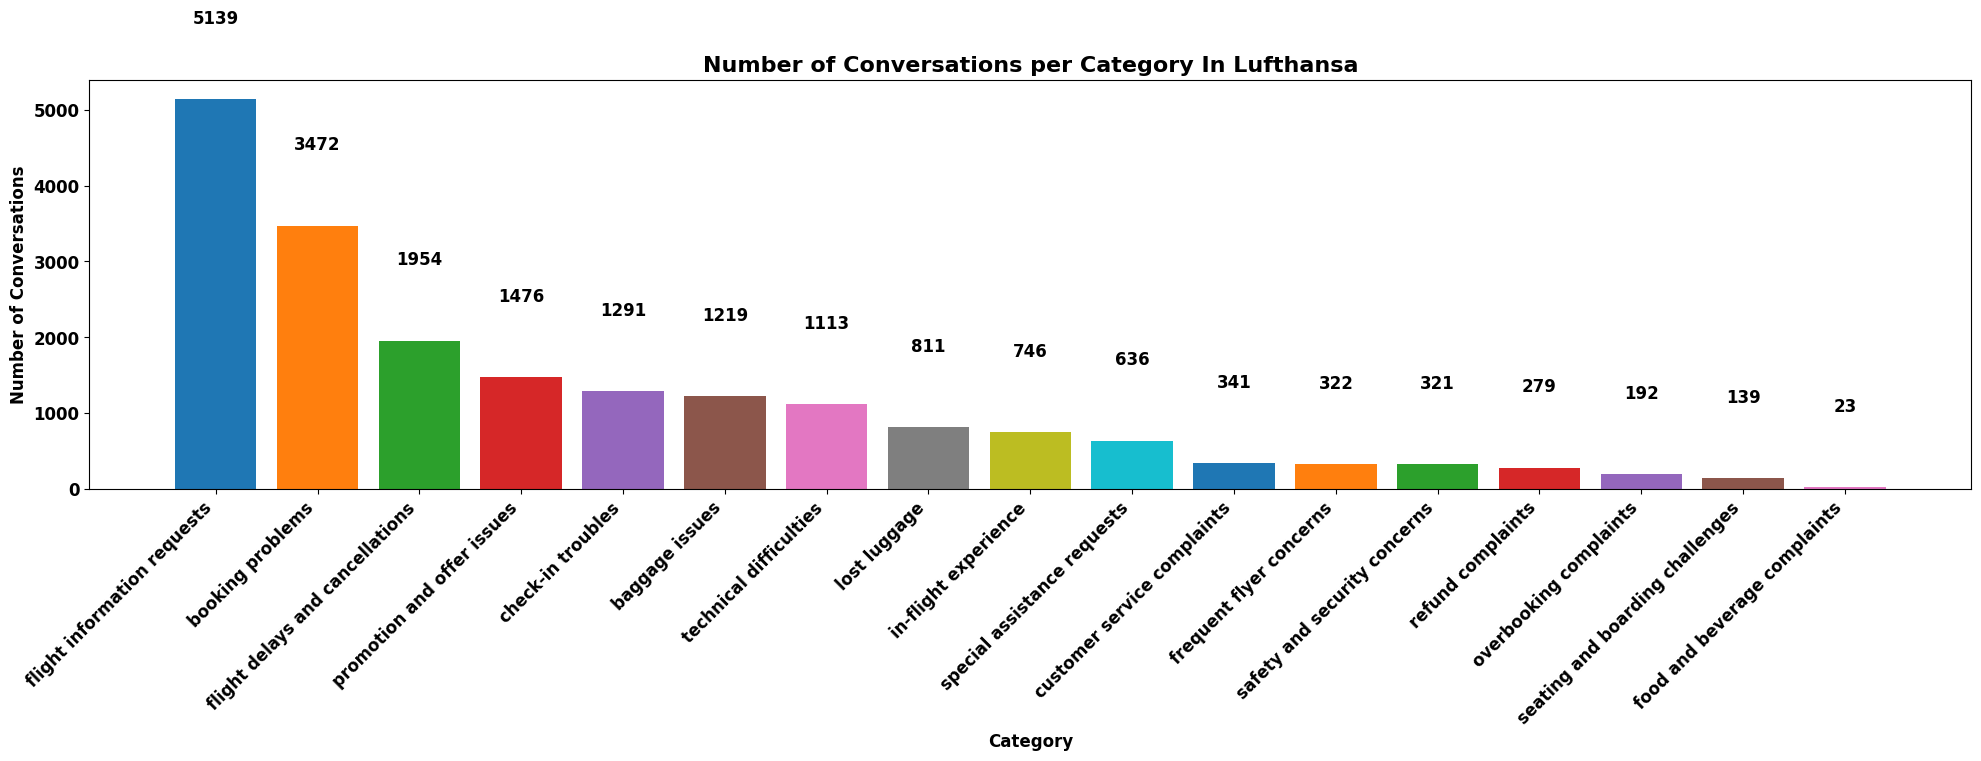

In [3]:
# Calculate the category counts
category_counts = df_merged[df_merged['airline']=='Lufthansa']['category'].value_counts()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Category In Lufthansa', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels


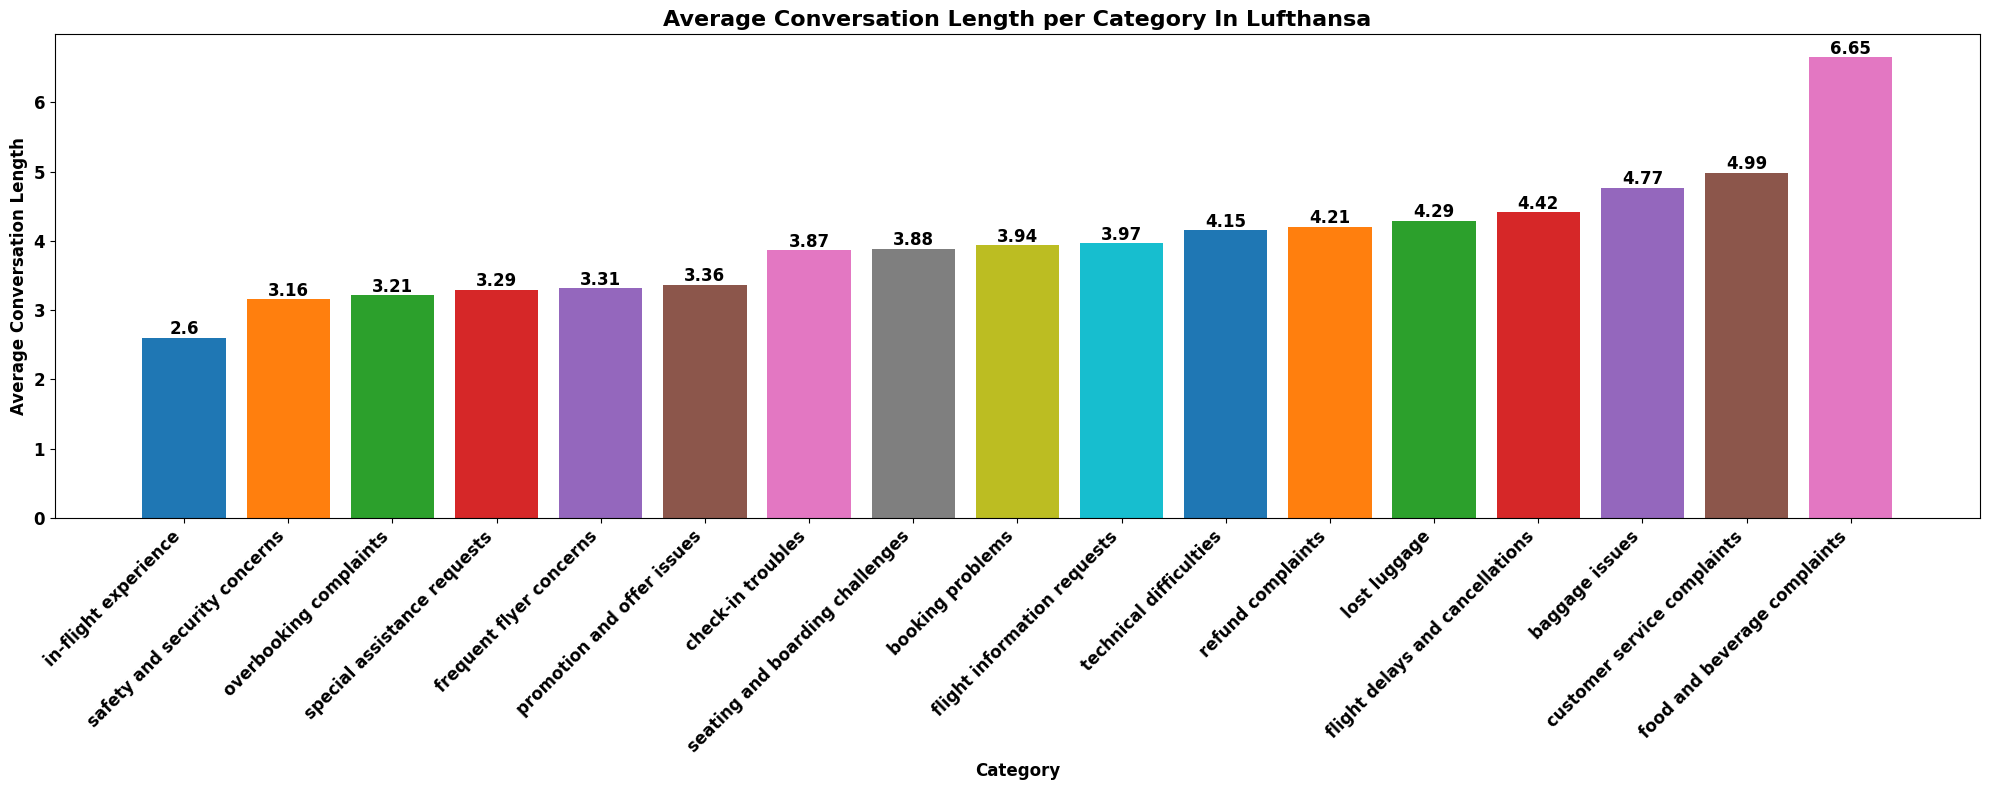

In [4]:
conversation_lengths = df_reset['conversation_id'].value_counts()

# Merge the conversation lengths with df_categories to get the category information
together = pd.merge(conversation_lengths, df_merged, on='conversation_id')

together = together[together['airline'] == "Lufthansa"]

# Compute the average conversation length per category
avg_conversation_length_per_category = together.groupby('category')['count'].mean().sort_values()


# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_conversation_length_per_category.index, avg_conversation_length_per_category.values, color=colors[:len(avg_conversation_length_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Conversation Length', fontsize=12, fontweight='bold')
plt.title('Average Conversation Length per Category In Lufthansa', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels



C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\775556664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lufthansa['tweet_creation_time'] = pd.to_datetime(df_lufthansa['tweet_creation_time'])
C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\775556664.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lufthansa['response_time'] = (df_lufthansa['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours


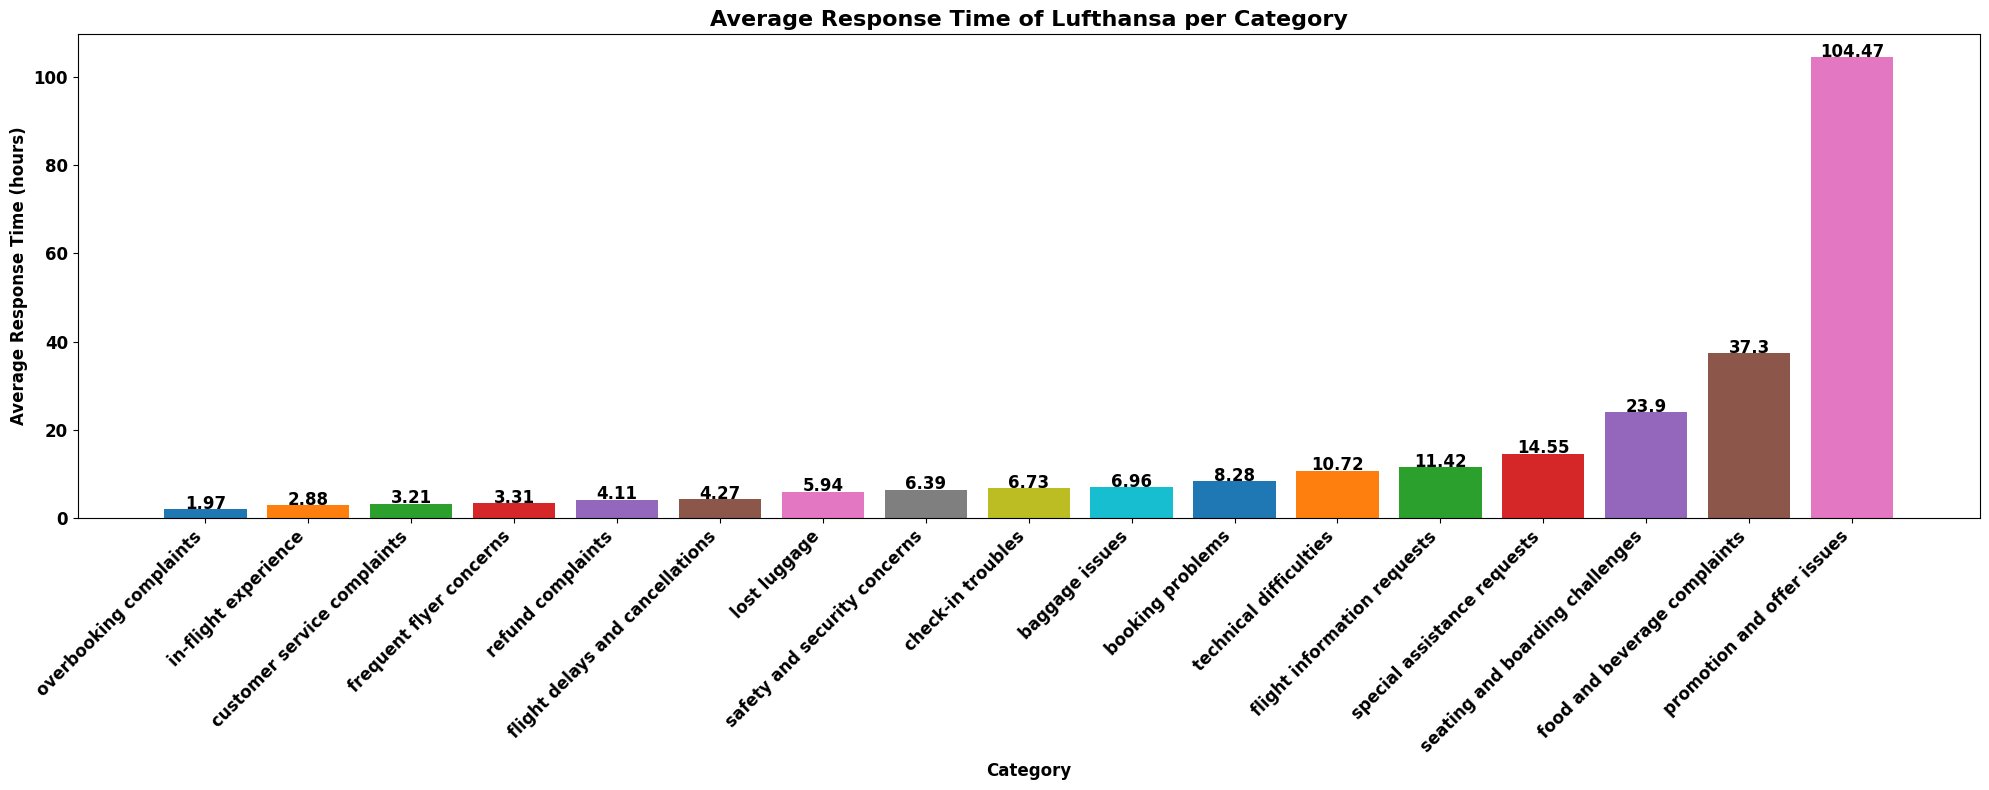

In [96]:
df_lufthansa = df_merged[(df_merged['airline'] == 'Lufthansa') & (df_merged['user_id'] == '124476322')]


# Ensure tweet_creation_time is in datetime format
df_lufthansa['tweet_creation_time'] = pd.to_datetime(df_lufthansa['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_lufthansa.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_lufthansa['response_time'] = (df_lufthansa['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours


# Compute the average response time per category
avg_response_time_per_category = df_lufthansa.groupby('category')['response_time'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_response_time_per_category.index, avg_response_time_per_category.values, color=colors[:len(avg_response_time_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Average Response Time of Lufthansa per Category', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

plt.show()


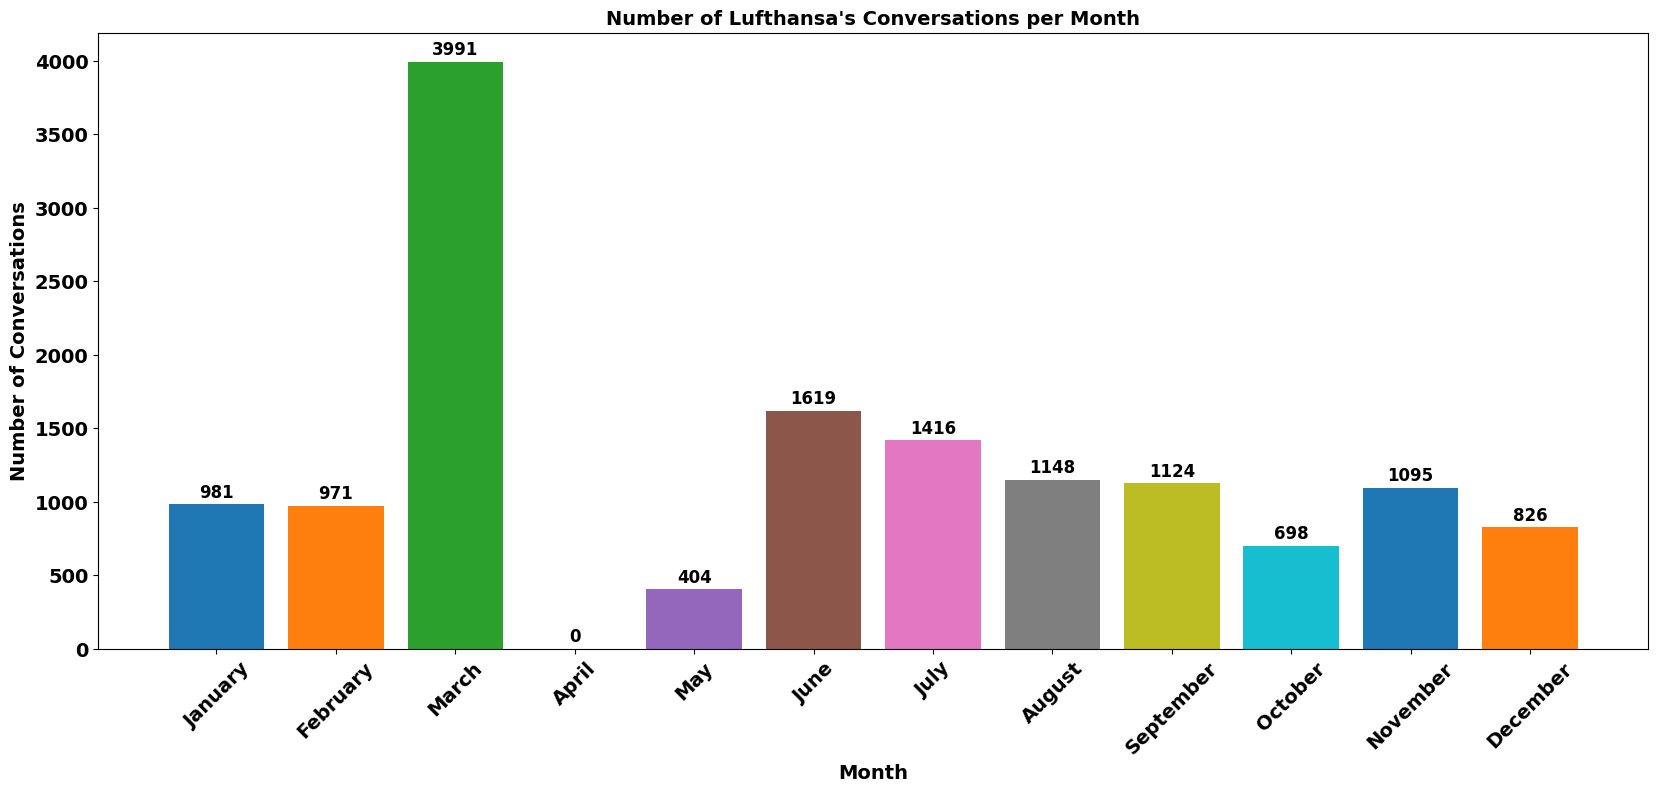

In [44]:
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=14, fontweight='bold')
plt.title("Number of Lufthansa's Conversations per Month", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold');


C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\983338006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


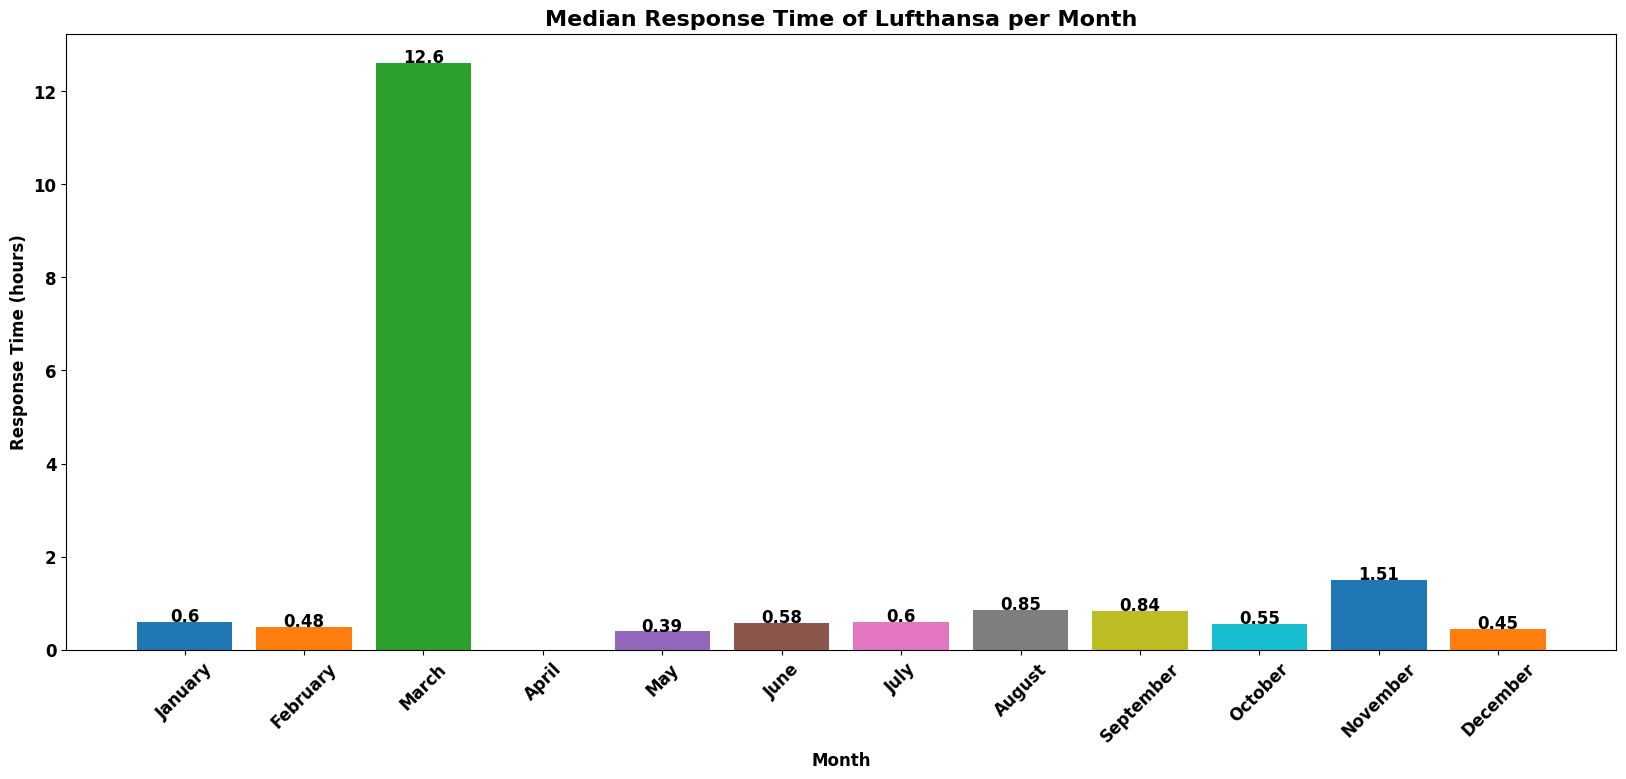

In [48]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract month from the tweet creation time
lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()

# Aggregate and compute the average response time for each month
average_response_times_per_month = lufthansa_replies.groupby('month')['response_time'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(average_response_times_per_month.index, average_response_times_per_month.values, color=colors[:len(average_response_times_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of Lufthansa per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


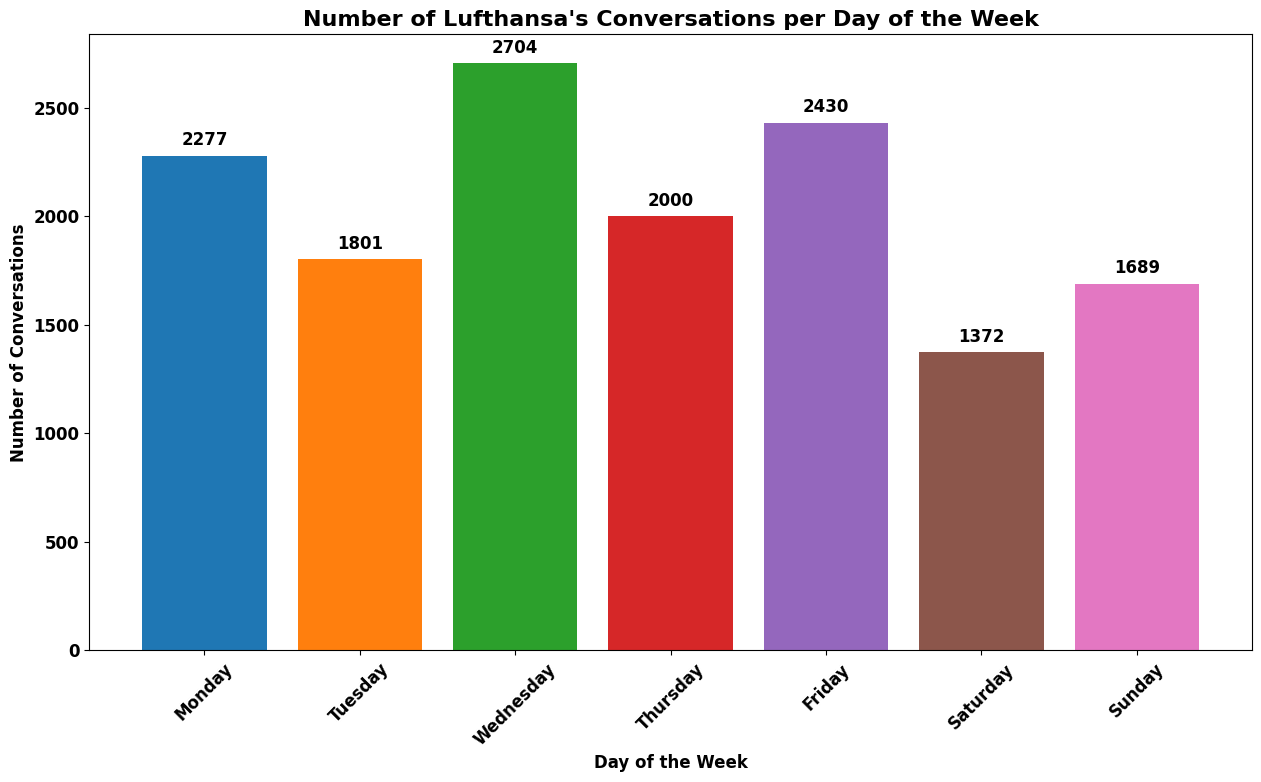

In [49]:
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the day name from the tweet creation time
first_tweet_times_day = first_tweet_times.dt.day_name()

# Group by day name and count the number of conversations
conversations_per_day = first_tweet_times_day.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title("Number of Lufthansa's Conversations per Day of the Week", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold')


C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\463625102.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['day_of_week'] = lufthansa_replies['tweet_creation_time'].dt.day_name()


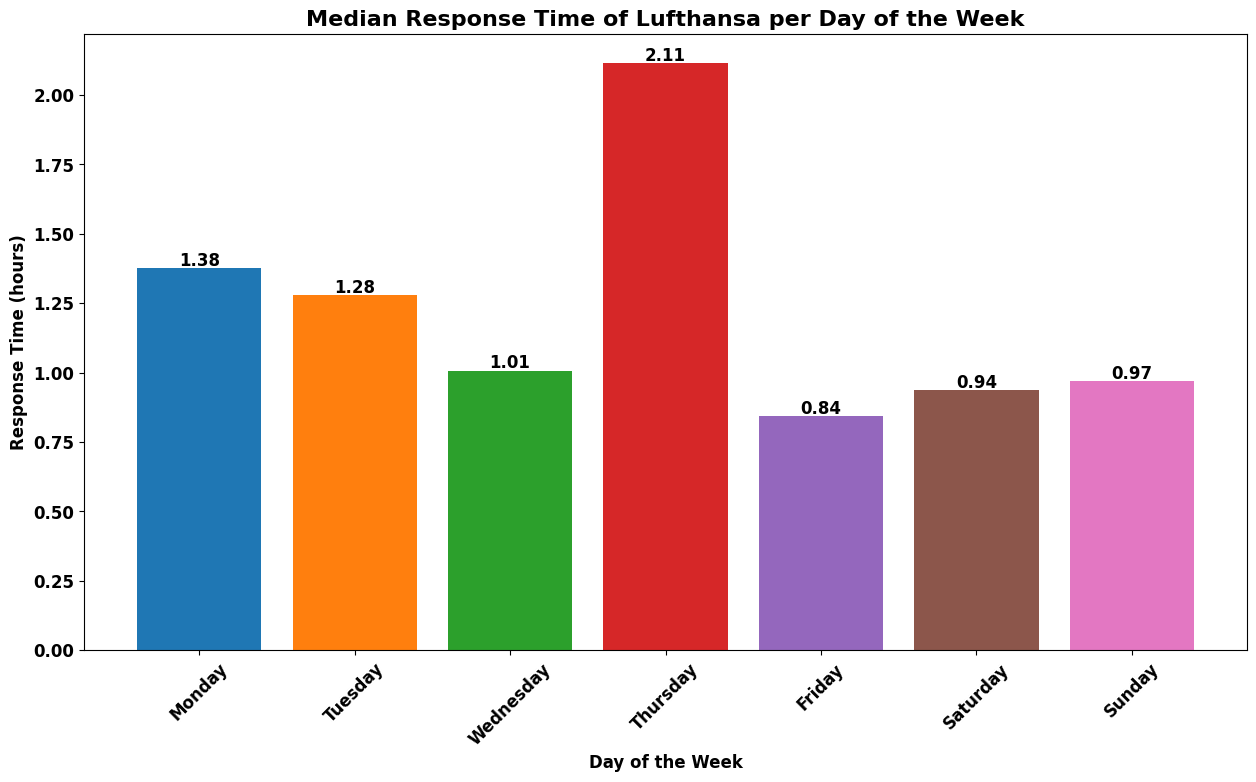

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract the day of the week from the tweet creation time
lufthansa_replies['day_of_week'] = lufthansa_replies['tweet_creation_time'].dt.day_name()

# Aggregate and compute the median response time for each day of the week
median_response_times_per_day = lufthansa_replies.groupby('day_of_week')['response_time'].median().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(median_response_times_per_day.index, median_response_times_per_day.values, color=colors[:len(median_response_times_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of Lufthansa per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.show()


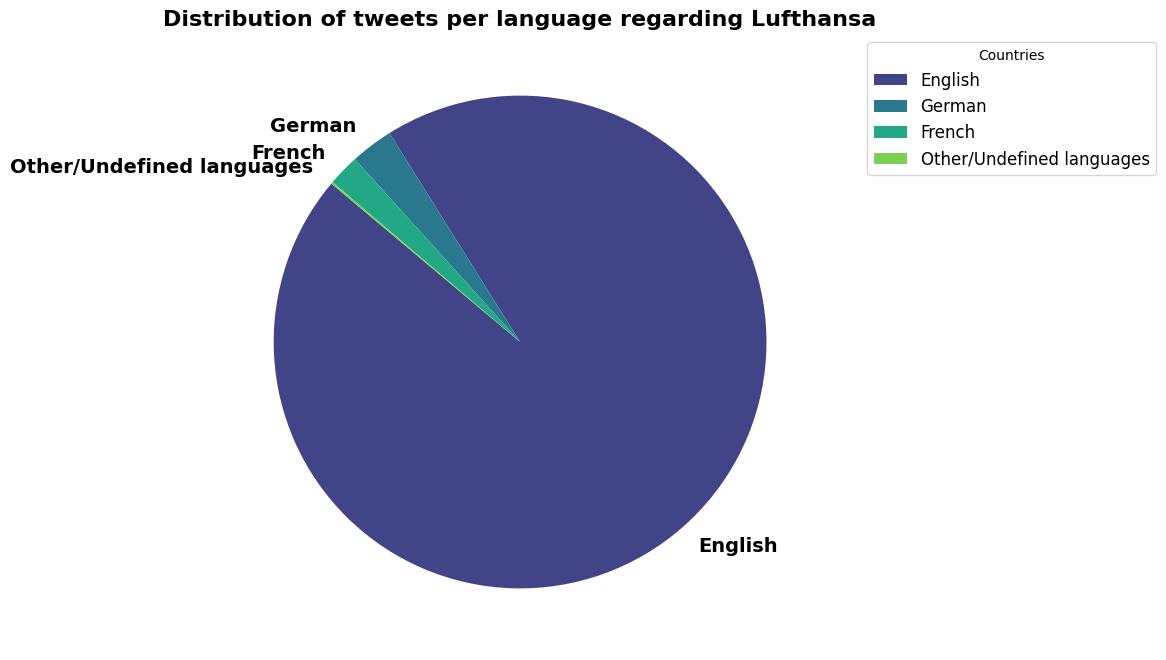

In [105]:
df_lufthansa_tweets = df_merged[df_merged['airline'] == "Lufthansa"]

df_lufthansa_tweets[df_lufthansa_tweets['lang'] == 'nl']

df_lang_distr = df_lufthansa_tweets.groupby('lang', observed=True)\
     [["user_id"]].count().sort_values('user_id', ascending=False)\
         .rename(columns={"user_id":"Tweets number"})

df_top_lang = df_lang_distr.nlargest(4, 'Tweets number')

df_other_lang = df_lang_distr.loc[~df_lang_distr.index.isin(df_top_lang.index)]

df_lang_agg = df_other_lang.sum()
df_lang_agg.name = 'Other languages'

df_lang_agg_final = pd.concat([df_top_lang, df_lang_agg.to_frame().T])
df_lang_agg_final.index.name = 'Language'
df_lang_agg_final.index = df_lang_agg_final.index.map(get_full_language_name)
# Rename "nl" to "Dutch"
df_lang_agg_final.rename(index={'nl': 'Dutch'}, inplace=True)



# Combine "Undefined Language" and "Other languages"
combined_count = df_lang_agg_final.loc['Undefined Language'].iloc[0] + df_lang_agg_final.loc['Other languages'].iloc[0]
df_lang_agg_final = df_lang_agg_final.drop(['Undefined Language', 'Other languages'])
df_lang_agg_final.loc['Other/Undefined languages'] = combined_count

plt.figure(figsize=(10, 8))
plt.pie(df_lang_agg_final["Tweets number"], labels=df_lang_agg_final.index,
        startangle=140, textprops={'fontsize': 14, 'weight': 'bold'},
        colors=sns.color_palette("viridis", len(df_lang_agg_final)))
plt.title('Distribution of tweets per language regarding Lufthansa', fontsize=16, weight='bold')
plt.legend(df_lang_agg_final.index, title="Countries",
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);
           


# EXTERNAL ANALYSIS

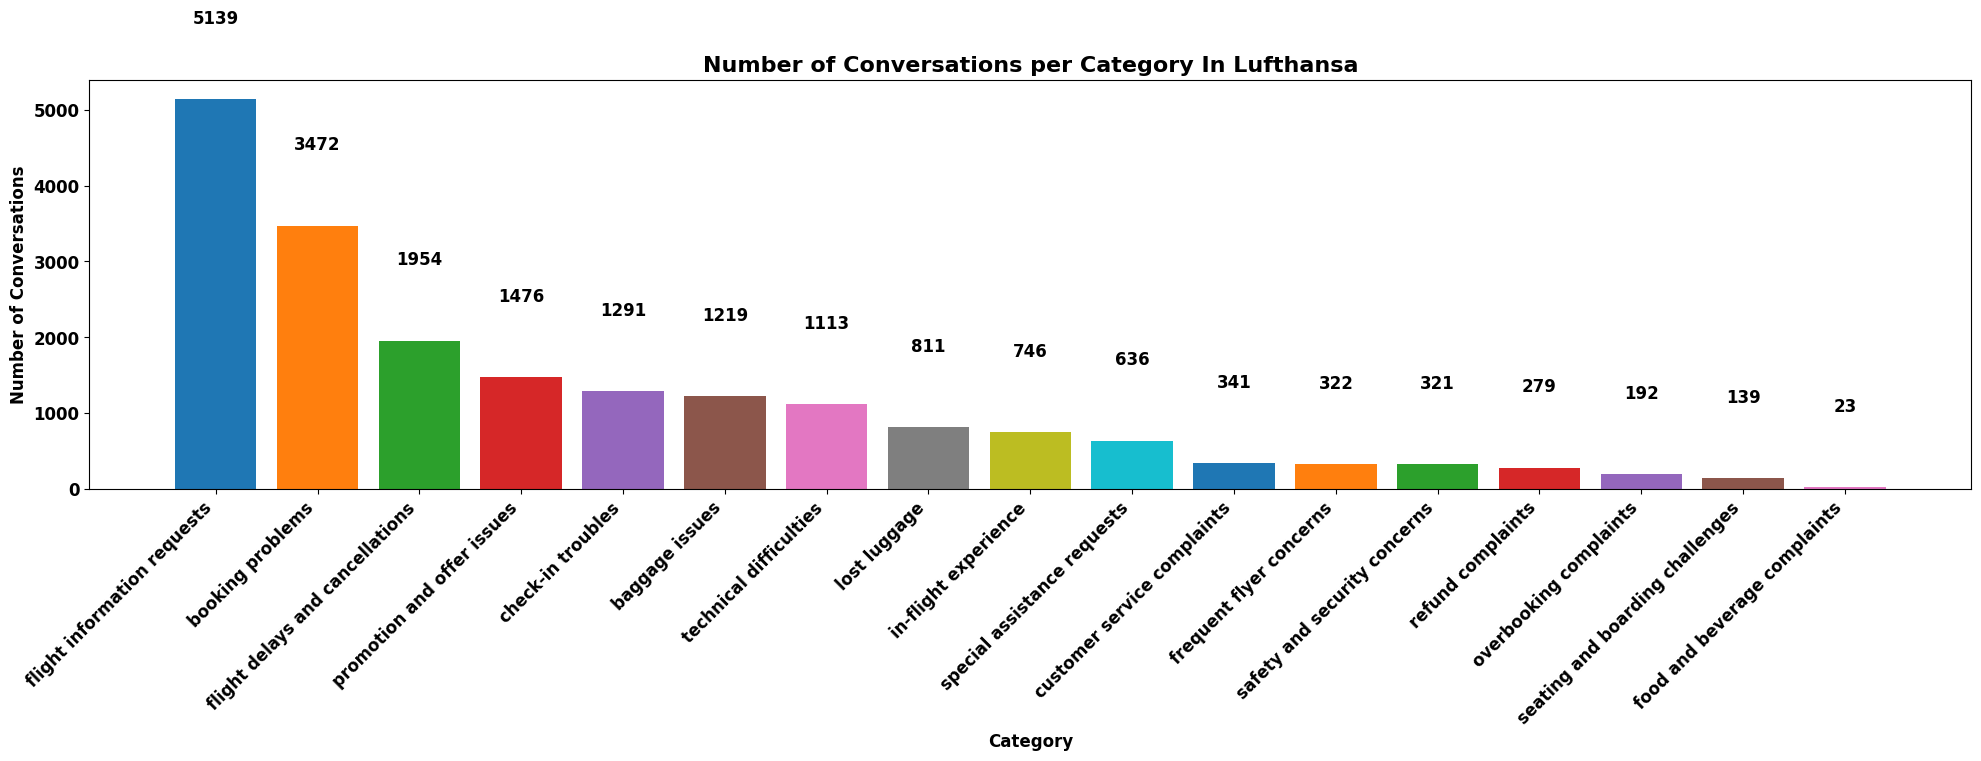

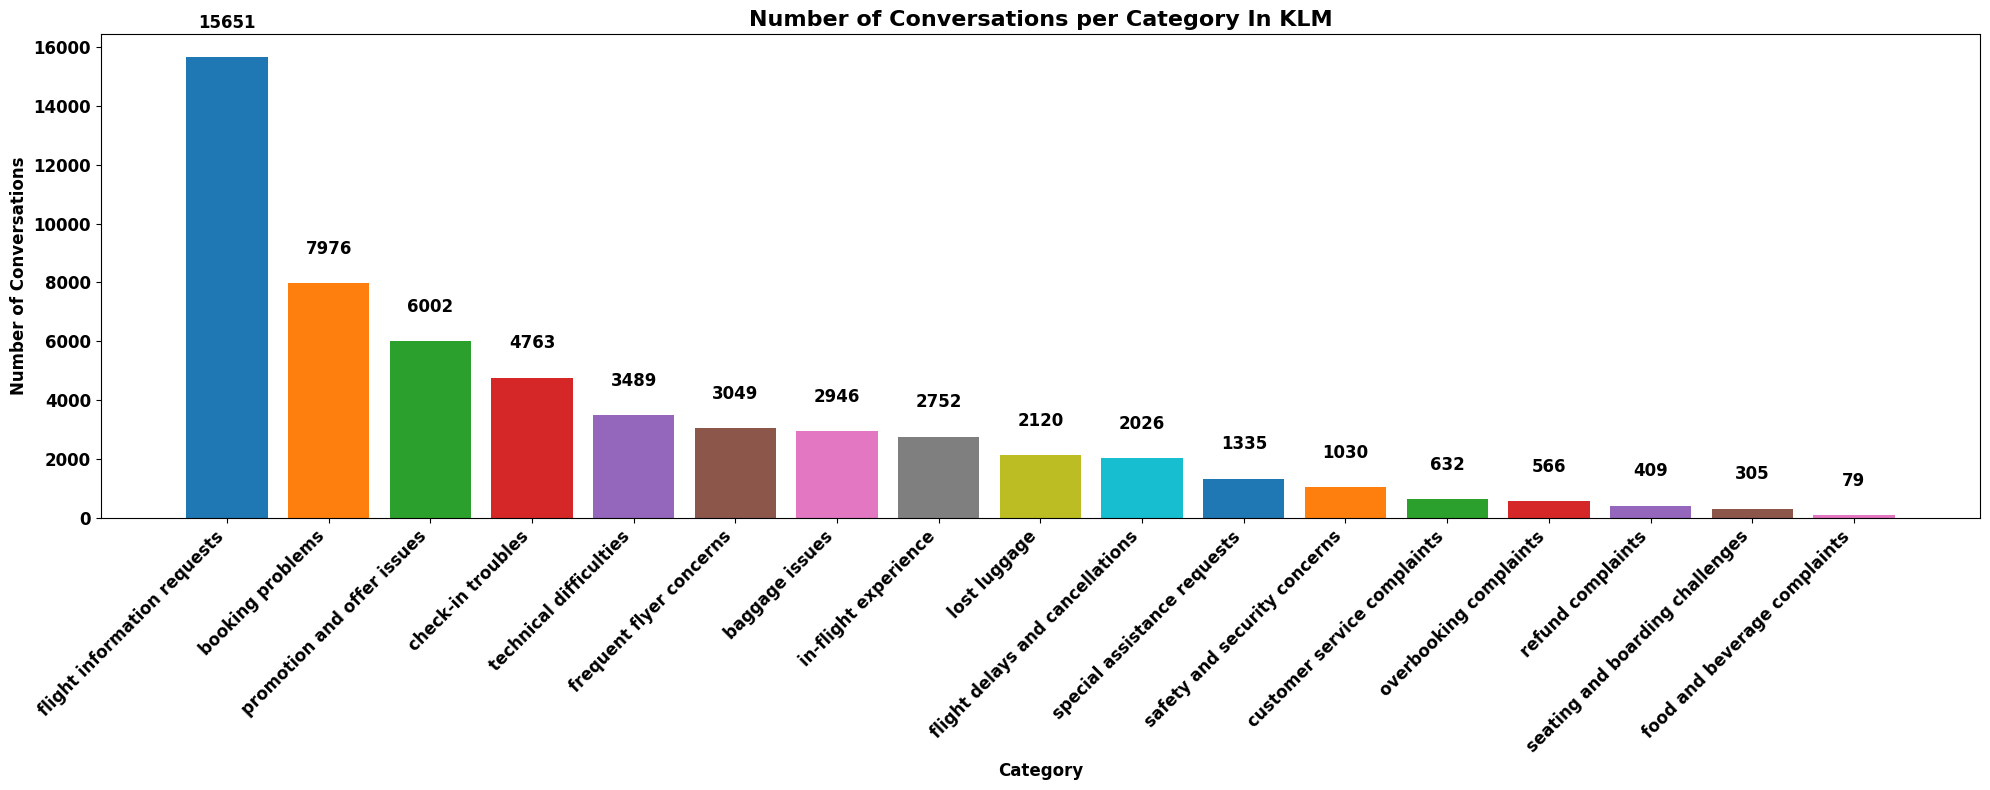

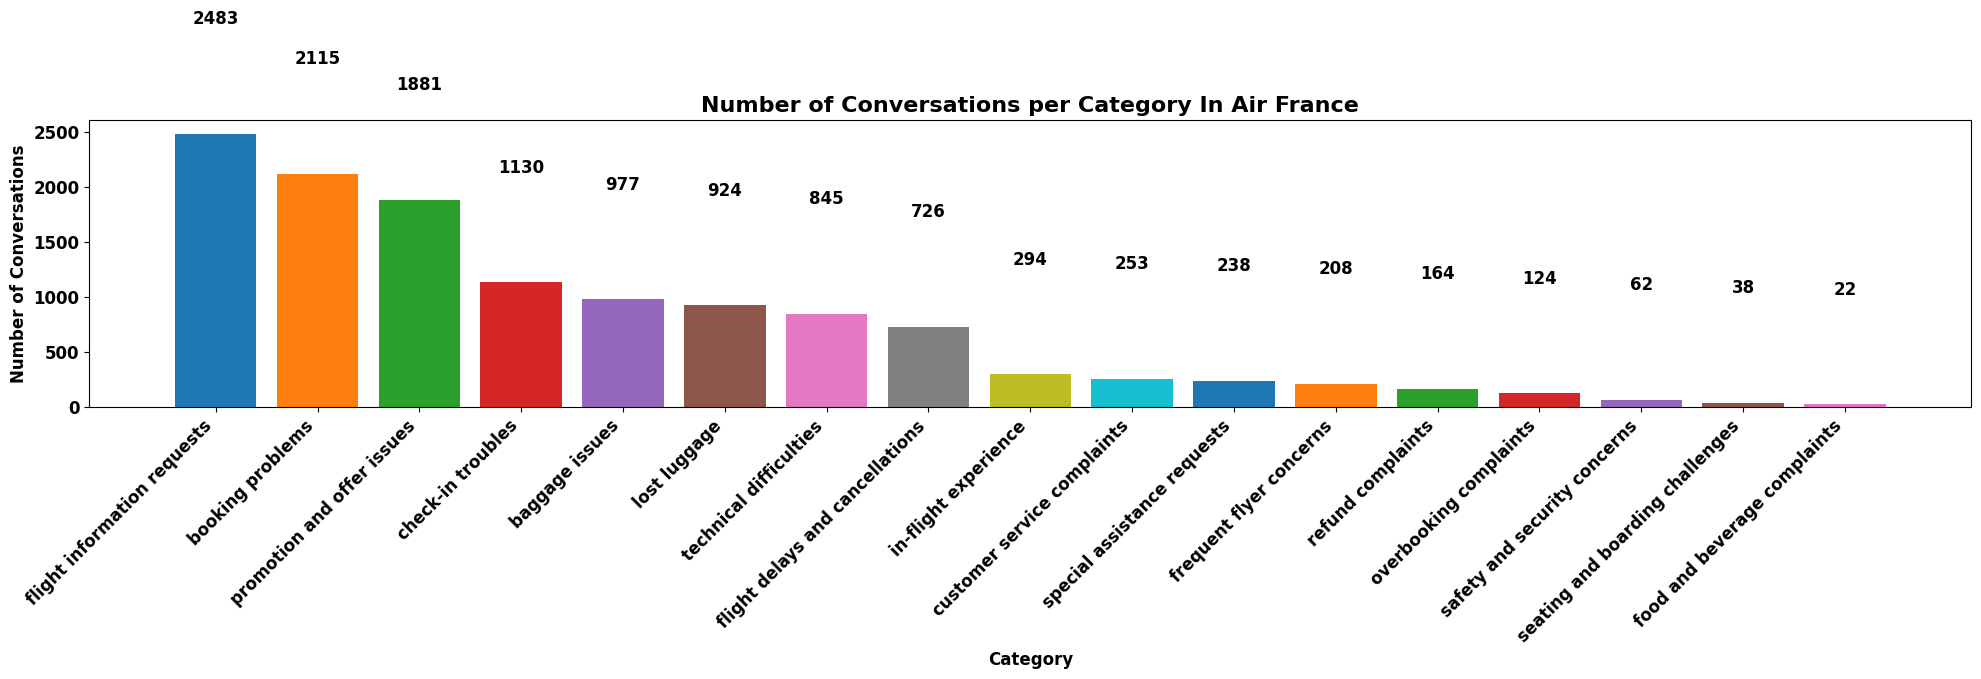

In [113]:
# Calculate the category counts
category_counts = df_merged[df_merged['airline']=='Lufthansa']['category'].value_counts()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Category In Lufthansa', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels


category_counts = df_merged[df_merged['airline']=='Klm']['category'].value_counts()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Category In KLM', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-label

category_counts = df_merged[df_merged['airline']=='Air France']['category'].value_counts()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Category In Air France', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-label




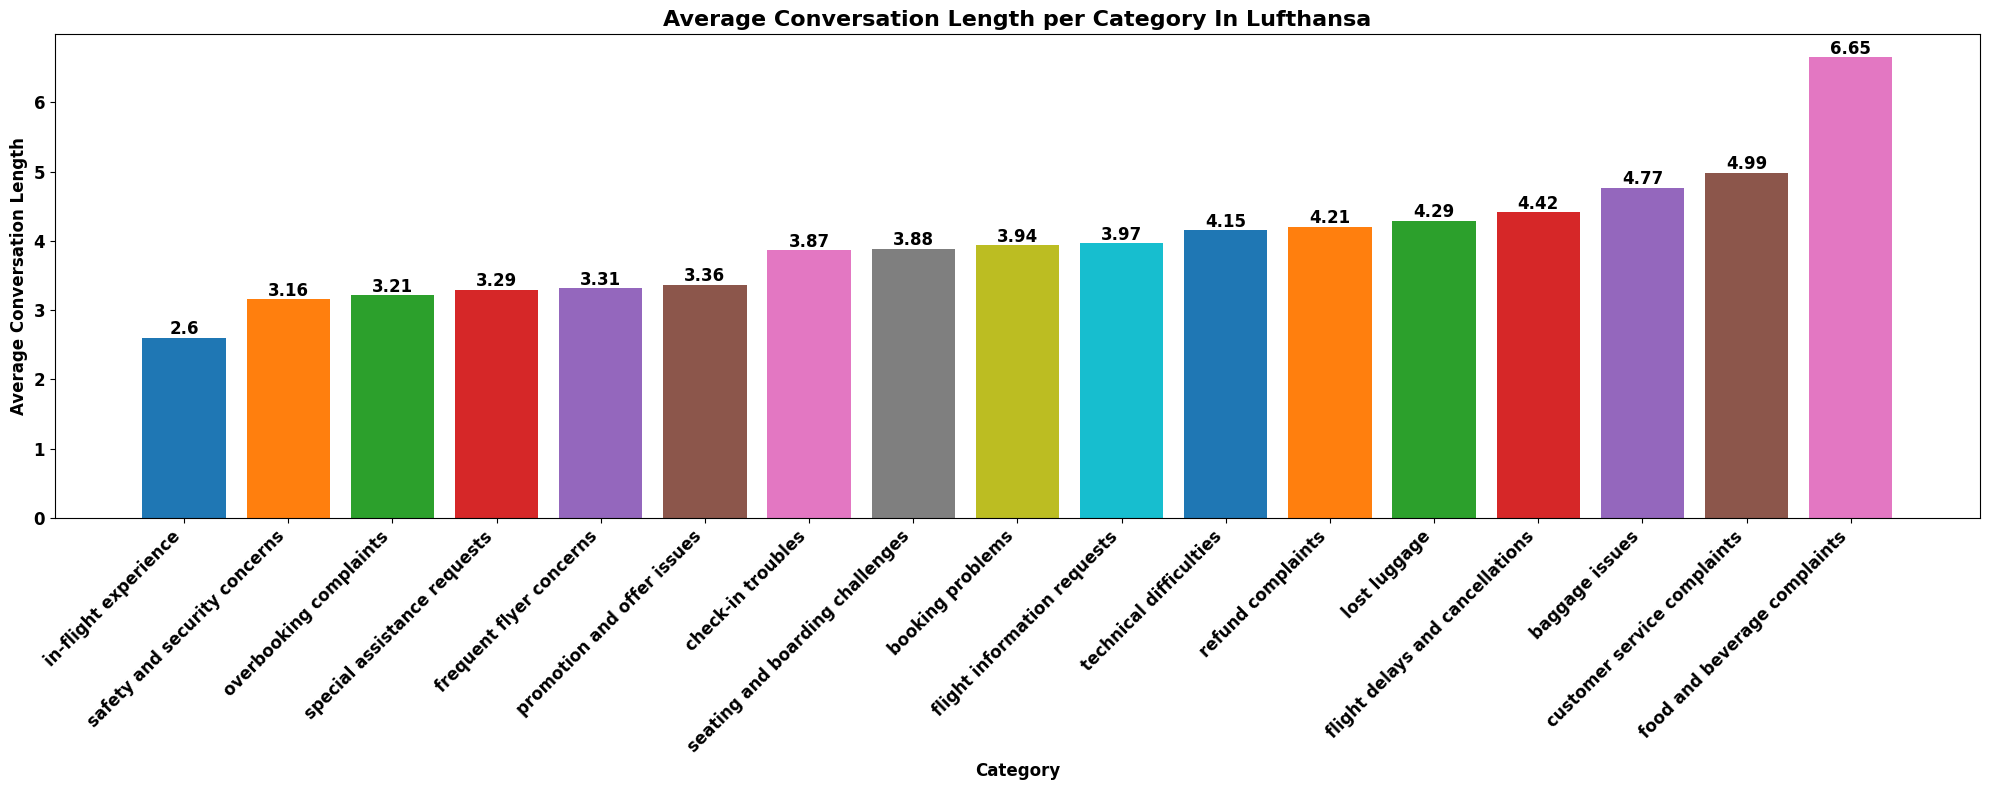

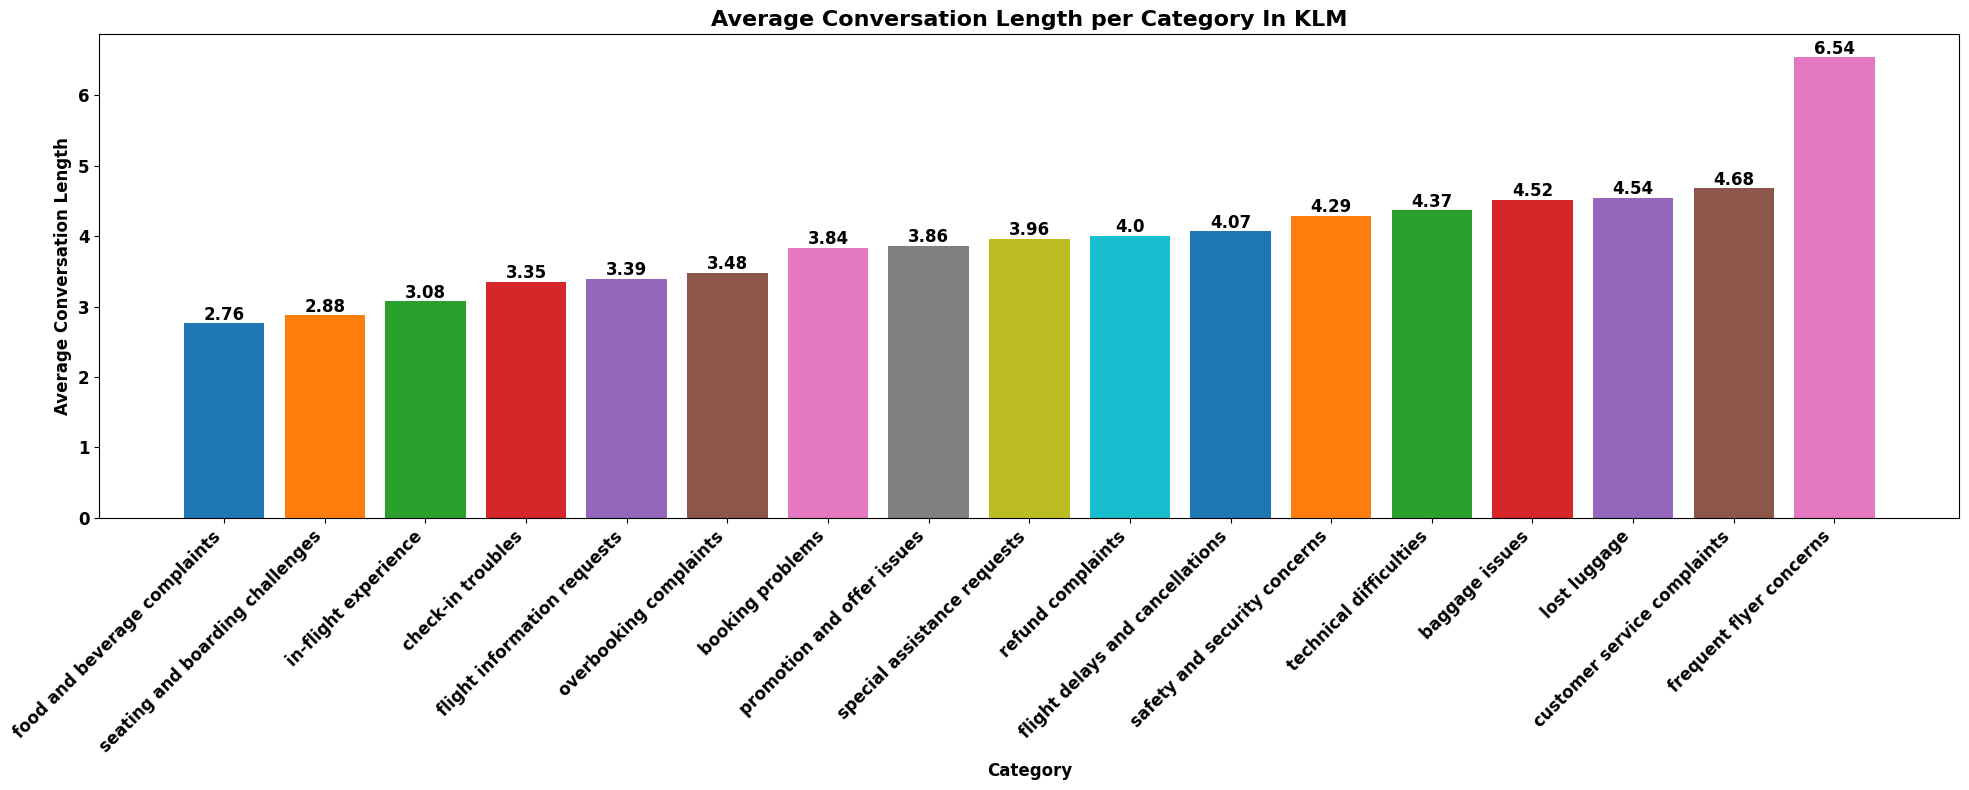

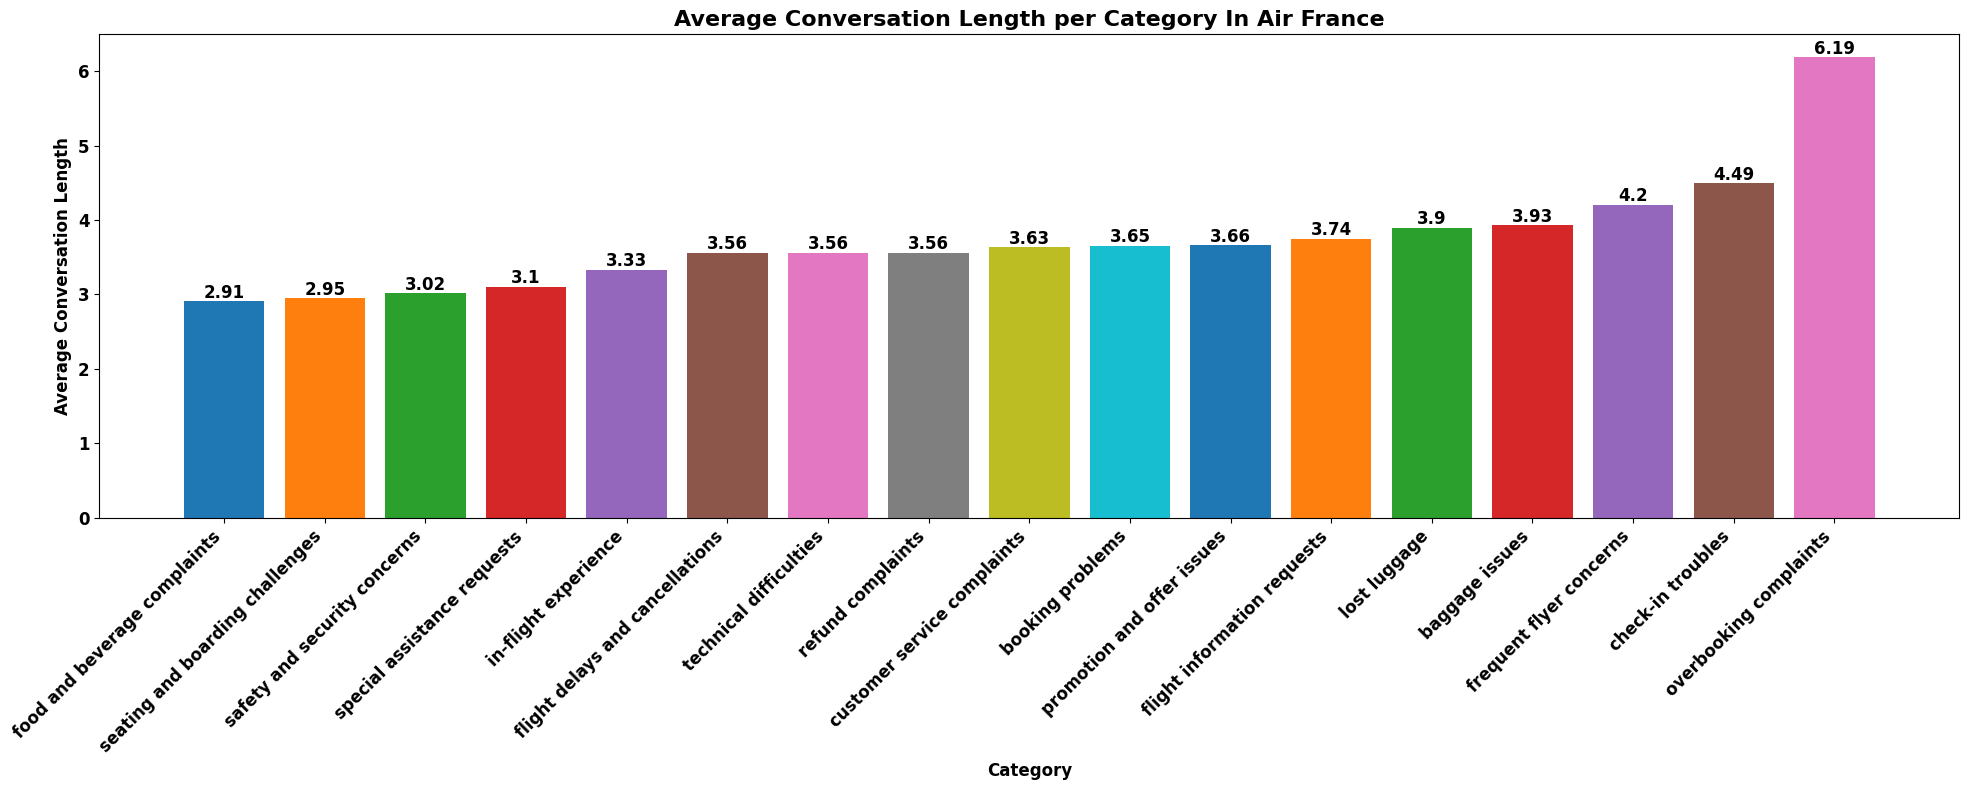

In [115]:
conversation_lengths = df_reset['conversation_id'].value_counts()

# Merge the conversation lengths with df_categories to get the category information
together = pd.merge(conversation_lengths, df_merged, on='conversation_id')

together = together[together['airline'] == "Lufthansa"]

# Compute the average conversation length per category
avg_conversation_length_per_category = together.groupby('category')['count'].mean().sort_values()


# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_conversation_length_per_category.index, avg_conversation_length_per_category.values, color=colors[:len(avg_conversation_length_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Conversation Length', fontsize=12, fontweight='bold')
plt.title('Average Conversation Length per Category In Lufthansa', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

#DJWOQIJDIOWQJDIOQWJIODJQWIODJQWIOJDIOQWJDIOQWJDIOJQWIODJQIODJIOQWJOI
conversation_lengths = df_reset['conversation_id'].value_counts()

# Merge the conversation lengths with df_categories to get the category information
together = pd.merge(conversation_lengths, df_merged, on='conversation_id')

together = together[together['airline'] == "Klm"]

# Compute the average conversation length per category
avg_conversation_length_per_category = together.groupby('category')['count'].mean().sort_values()


# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_conversation_length_per_category.index, avg_conversation_length_per_category.values, color=colors[:len(avg_conversation_length_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Conversation Length', fontsize=12, fontweight='bold')
plt.title('Average Conversation Length per Category In KLM', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels


#diwoqdjqwoidjqwiodjqwiojdioqwjdioqwjdoiqwjdiq
conversation_lengths = df_reset['conversation_id'].value_counts()

# Merge the conversation lengths with df_categories to get the category information
together = pd.merge(conversation_lengths, df_merged, on='conversation_id')

together = together[together['airline'] == "Air France"]

# Compute the average conversation length per category
avg_conversation_length_per_category = together.groupby('category')['count'].mean().sort_values()


# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_conversation_length_per_category.index, avg_conversation_length_per_category.values, color=colors[:len(avg_conversation_length_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Conversation Length', fontsize=12, fontweight='bold')
plt.title('Average Conversation Length per Category In Air France', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels



C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\95618601.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lufthansa['tweet_creation_time'] = pd.to_datetime(df_lufthansa['tweet_creation_time'])
C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\95618601.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lufthansa['response_time'] = (df_lufthansa['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours


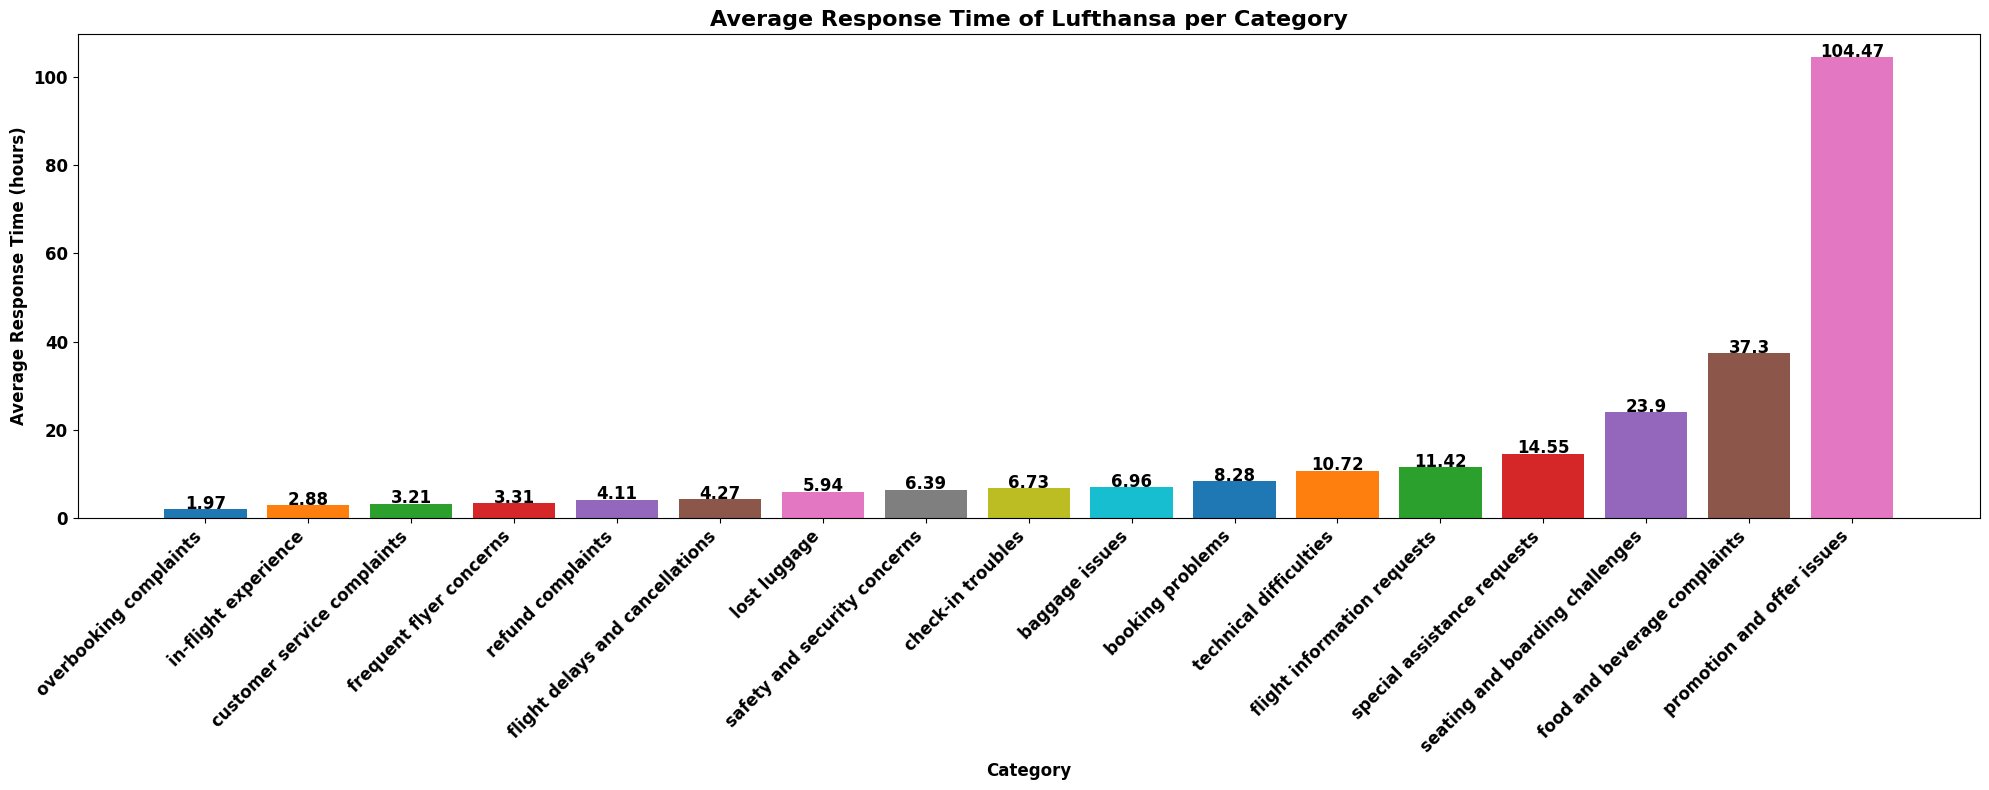

C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\95618601.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lufthansa['tweet_creation_time'] = pd.to_datetime(df_lufthansa['tweet_creation_time'])
C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\95618601.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lufthansa['response_time'] = (df_lufthansa['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours


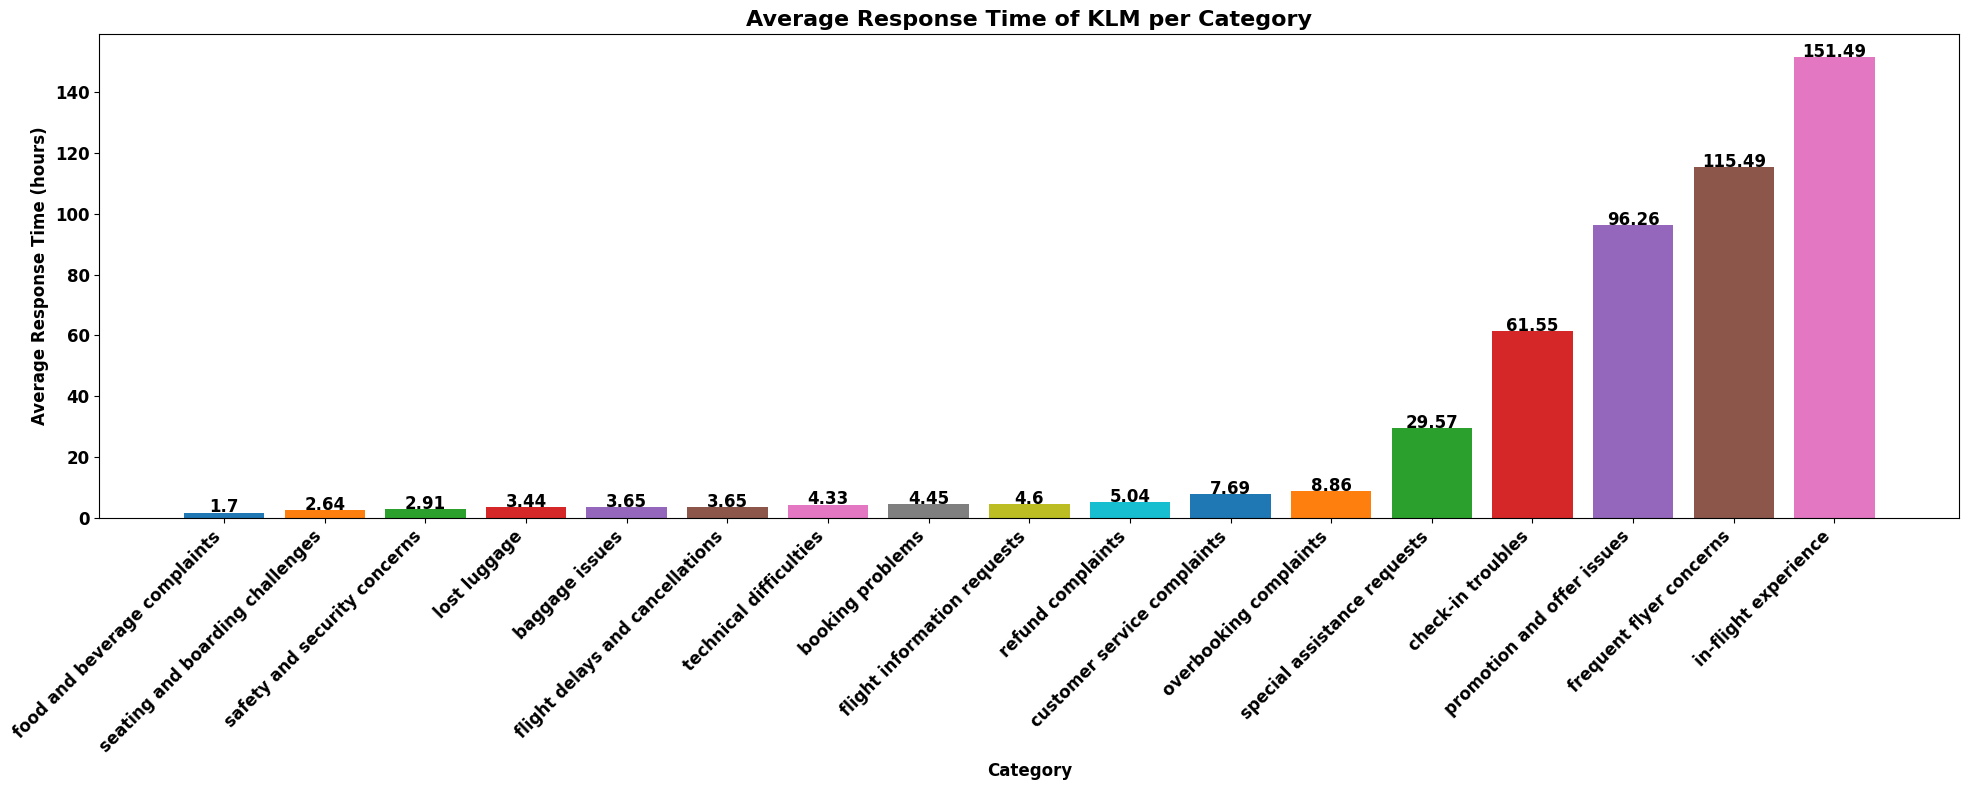

C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\95618601.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lufthansa['tweet_creation_time'] = pd.to_datetime(df_lufthansa['tweet_creation_time'])
C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\95618601.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lufthansa['response_time'] = (df_lufthansa['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours


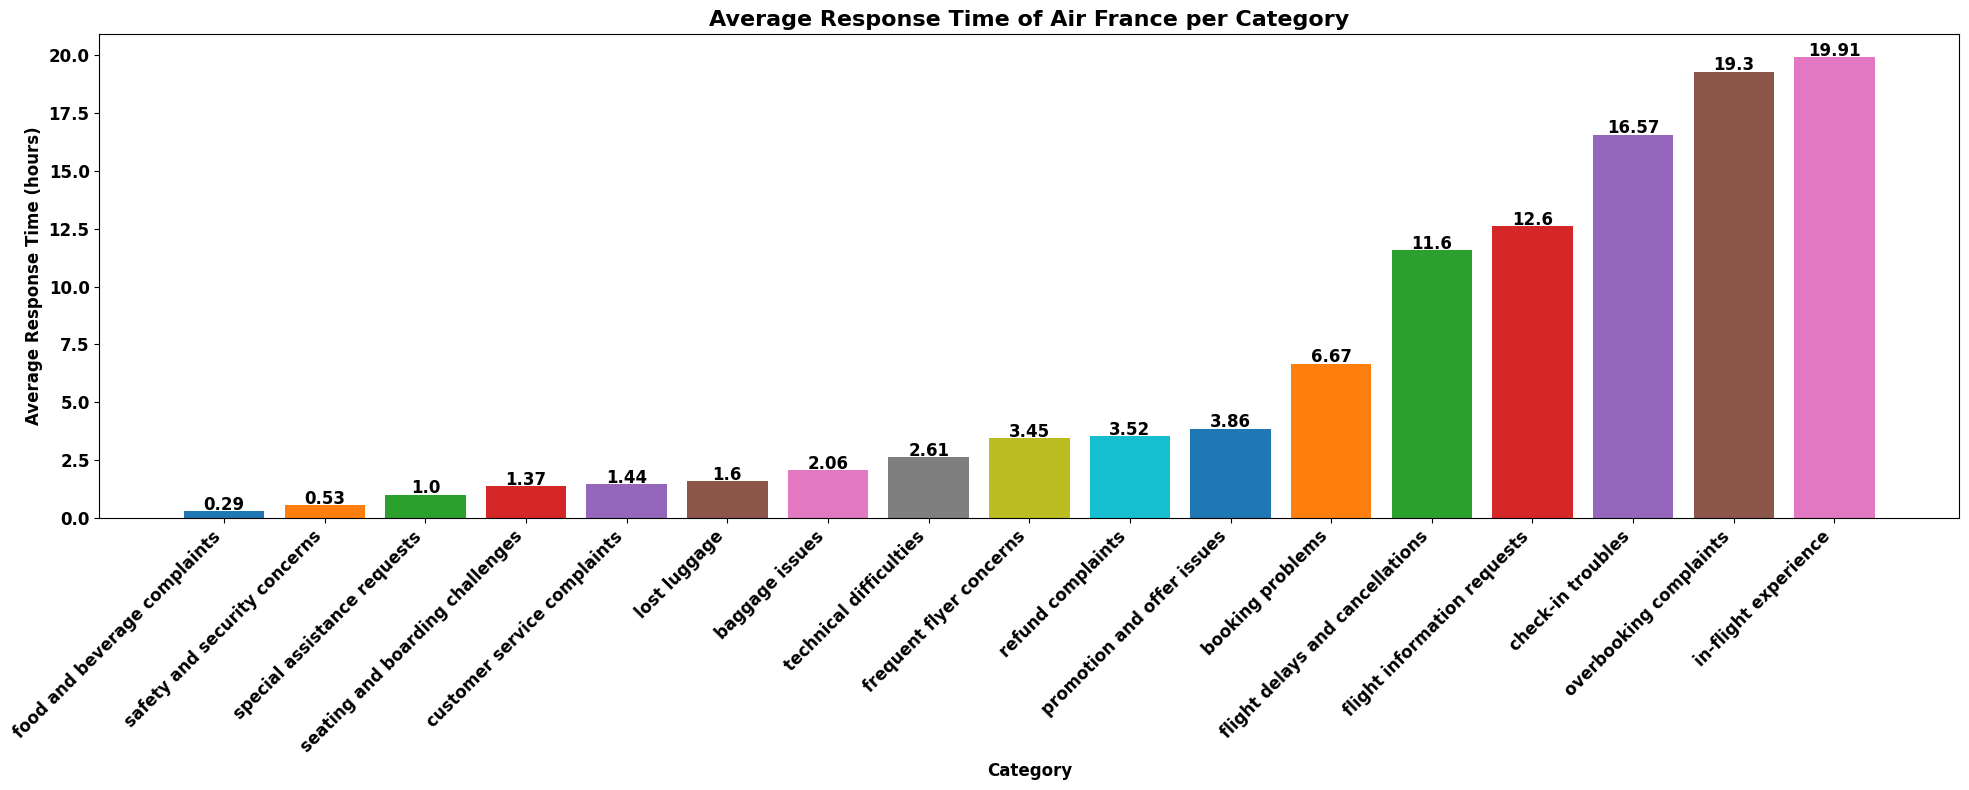

In [117]:
df_lufthansa = df_merged[(df_merged['airline'] == 'Lufthansa') & (df_merged['user_id'] == '124476322')]


# Ensure tweet_creation_time is in datetime format
df_lufthansa['tweet_creation_time'] = pd.to_datetime(df_lufthansa['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_lufthansa.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_lufthansa['response_time'] = (df_lufthansa['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours


# Compute the average response time per category
avg_response_time_per_category = df_lufthansa.groupby('category')['response_time'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_response_time_per_category.index, avg_response_time_per_category.values, color=colors[:len(avg_response_time_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Average Response Time of Lufthansa per Category', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

plt.show()

#idqwjiqojdiowqjdioqwjdioqwjdioqwjdioqwjdiojqwoidjqwi
df_lufthansa = df_merged[(df_merged['airline'] == 'Klm') & (df_merged['user_id'] == '56377143')]


# Ensure tweet_creation_time is in datetime format
df_lufthansa['tweet_creation_time'] = pd.to_datetime(df_lufthansa['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_lufthansa.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_lufthansa['response_time'] = (df_lufthansa['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours


# Compute the average response time per category
avg_response_time_per_category = df_lufthansa.groupby('category')['response_time'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_response_time_per_category.index, avg_response_time_per_category.values, color=colors[:len(avg_response_time_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Average Response Time of KLM per Category', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

plt.show()

df_lufthansa = df_merged[(df_merged['airline'] == 'Air France') & (df_merged['user_id'] == '106062176')]


# Ensure tweet_creation_time is in datetime format
df_lufthansa['tweet_creation_time'] = pd.to_datetime(df_lufthansa['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_lufthansa.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_lufthansa['response_time'] = (df_lufthansa['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours


# Compute the average response time per category
avg_response_time_per_category = df_lufthansa.groupby('category')['response_time'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_response_time_per_category.index, avg_response_time_per_category.values, color=colors[:len(avg_response_time_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Average Response Time of Air France per Category', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

plt.show()


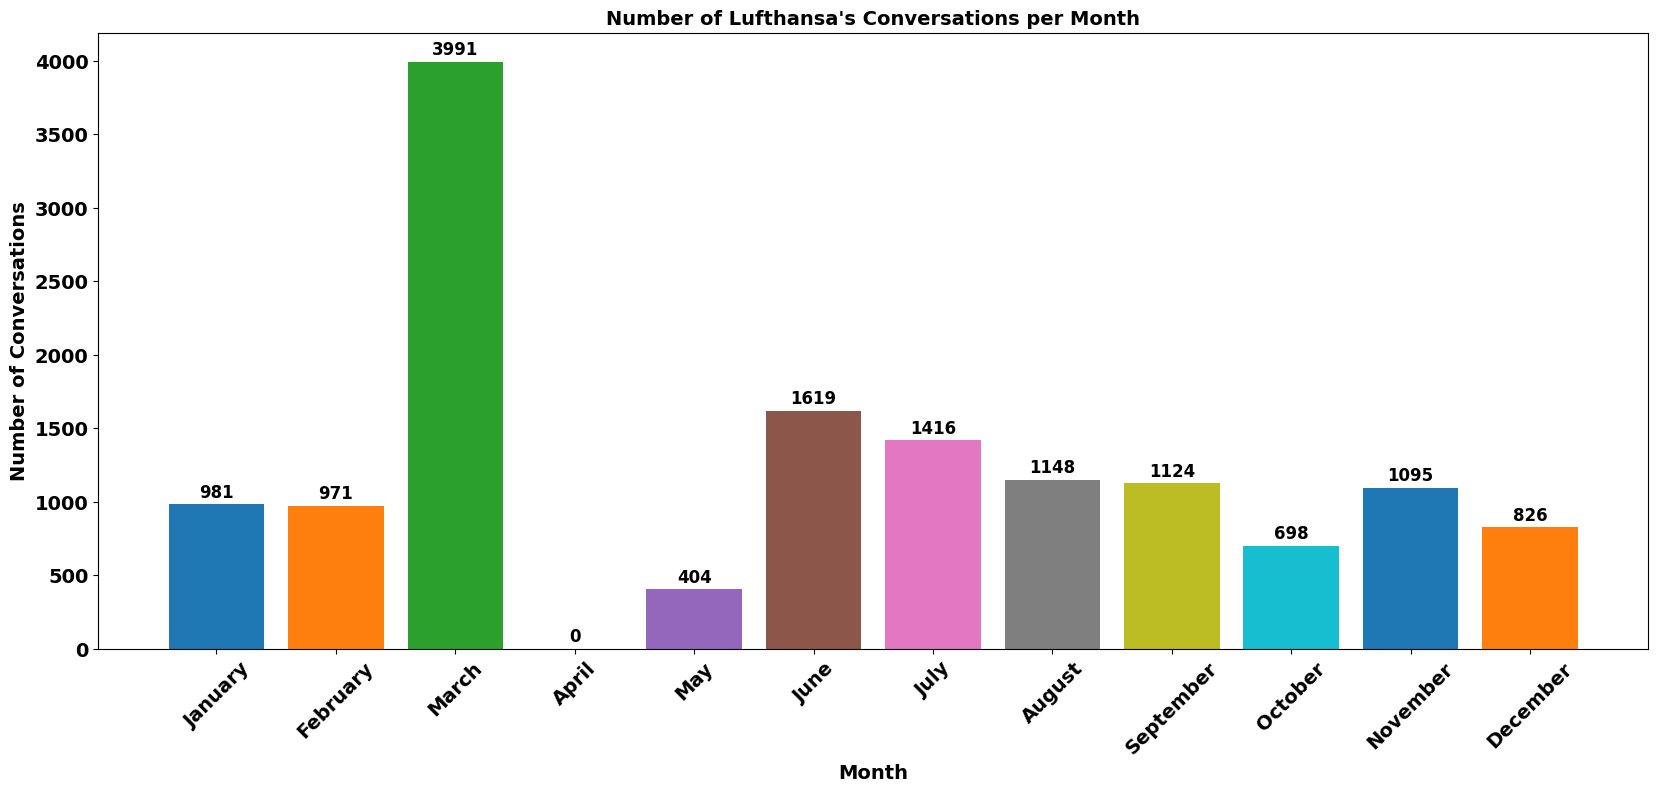

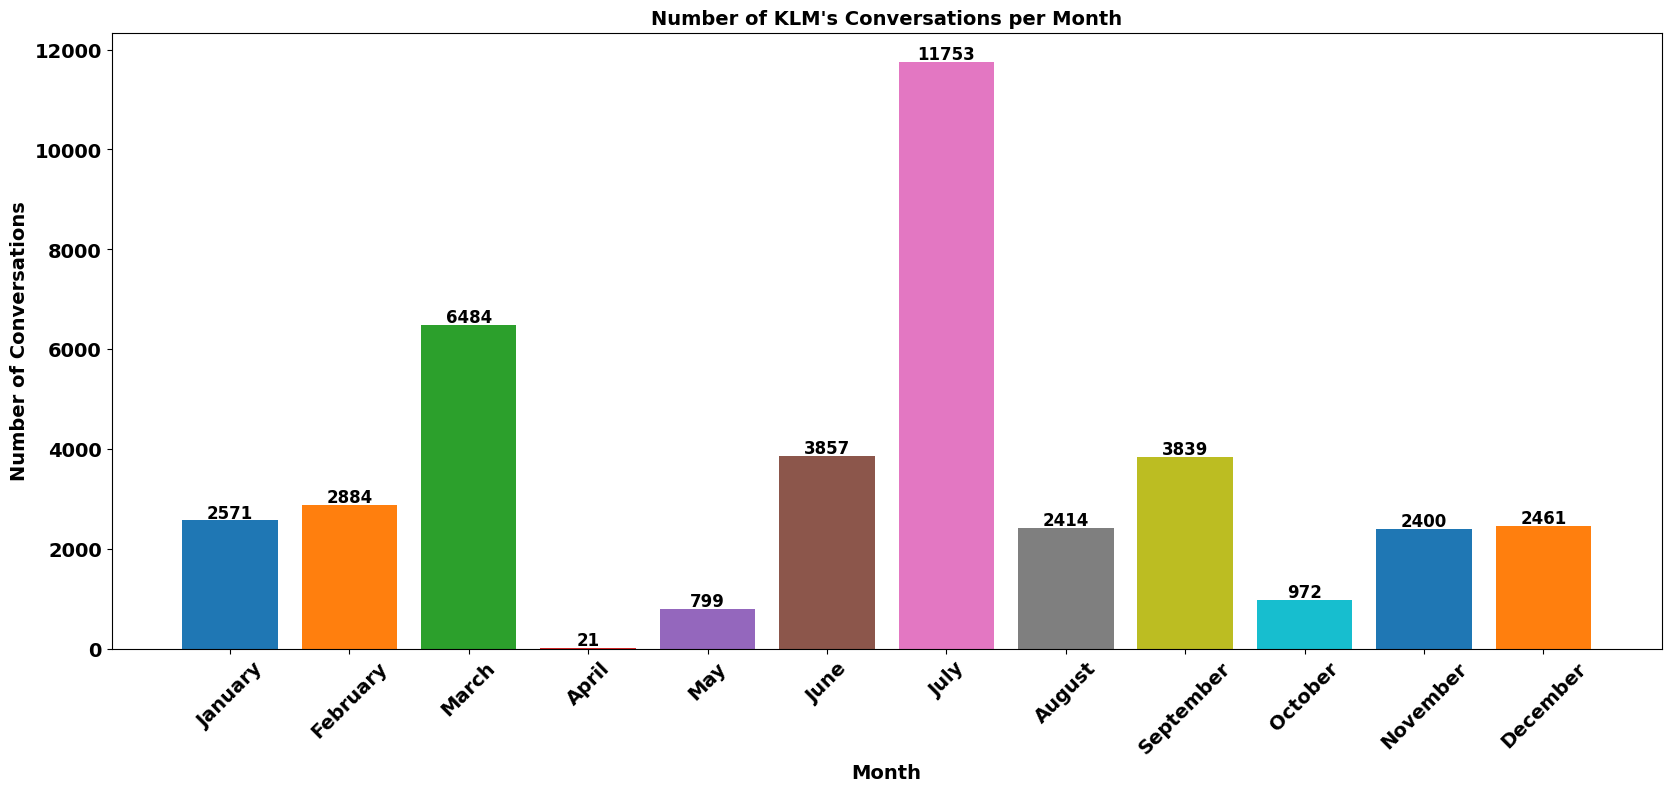

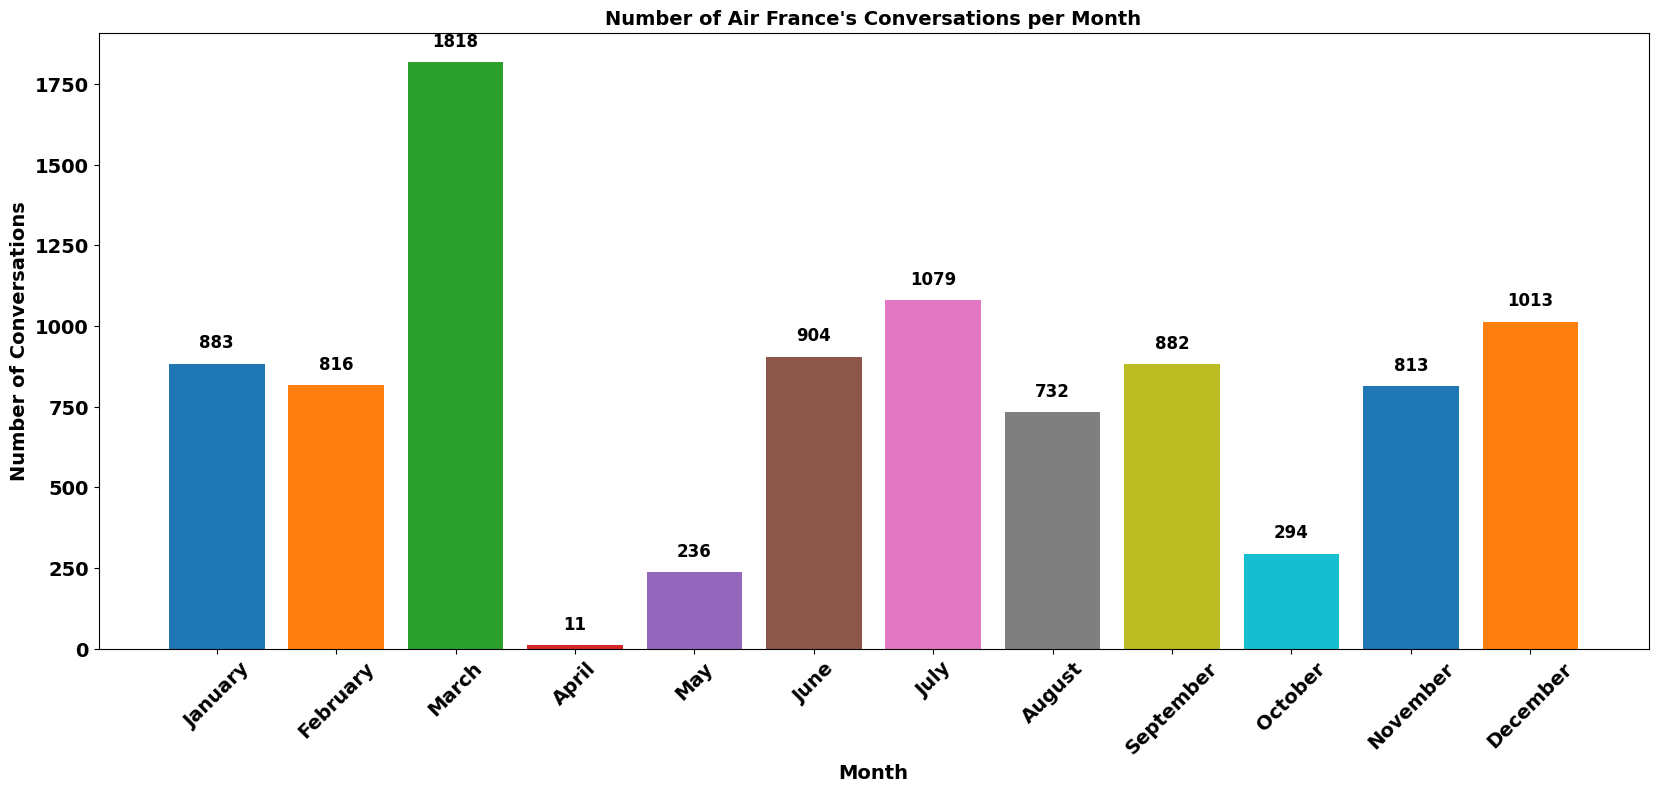

In [119]:
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=14, fontweight='bold')
plt.title("Number of Lufthansa's Conversations per Month", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold');

#DWIQJDOIQWJDIOQWJDOIQWJDOIQWJDOIQJIOWJ
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Klm"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=14, fontweight='bold')
plt.title("Number of KLM's Conversations per Month", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold');

#IDOWJQOIDJIOQWJDIOQWJDIOQWJOIDQ
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Air France"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=14, fontweight='bold')
plt.title("Number of Air France's Conversations per Month", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold');




C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\1880764096.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()
C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\1880764096.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()
C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\1880764096.py:97: SettingWithCopyWarning: 
A value is tr

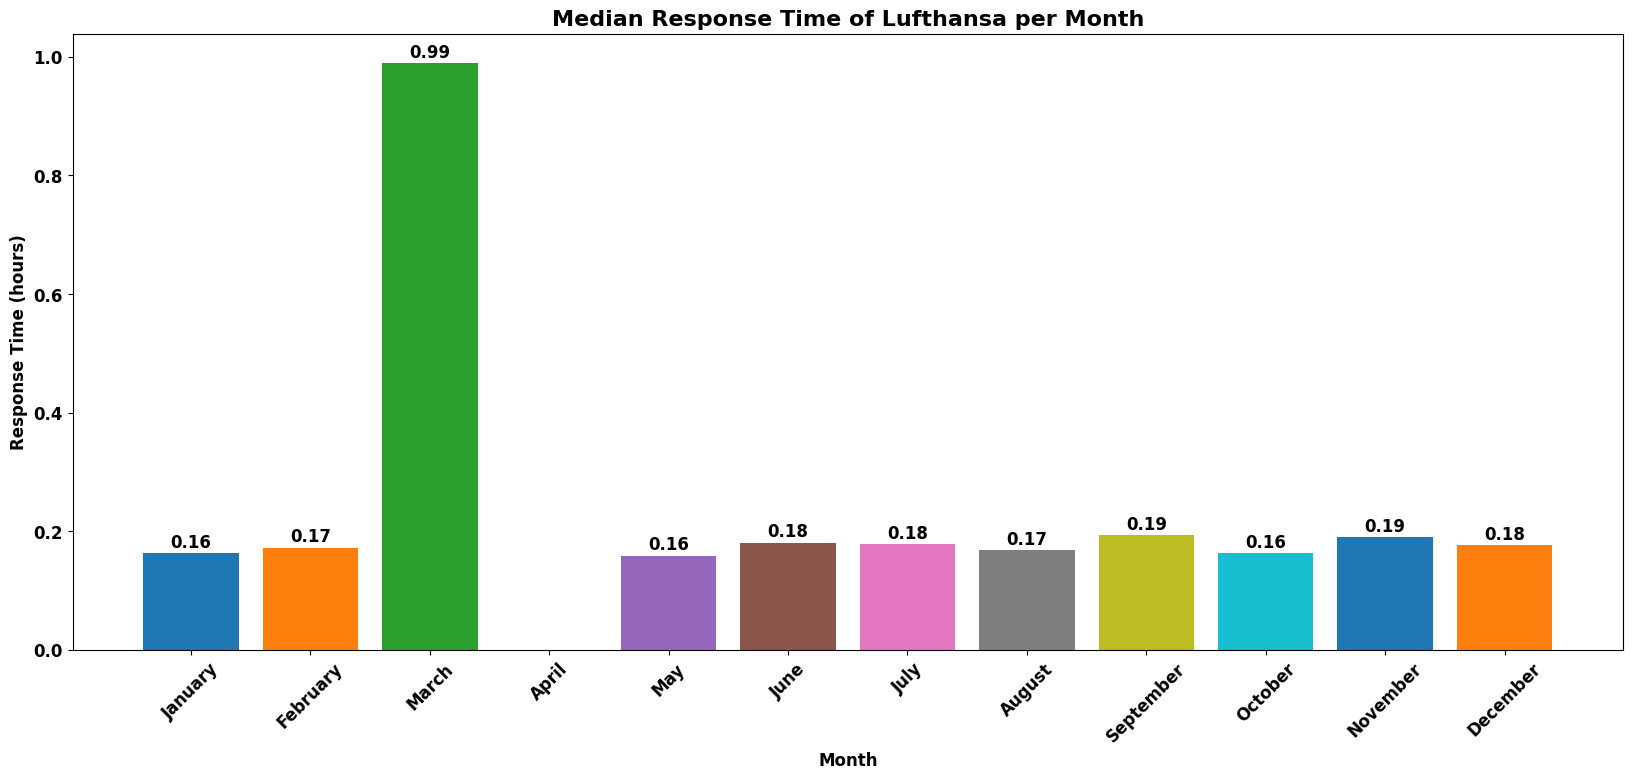

posx and posy should be finite values
posx and posy should be finite values


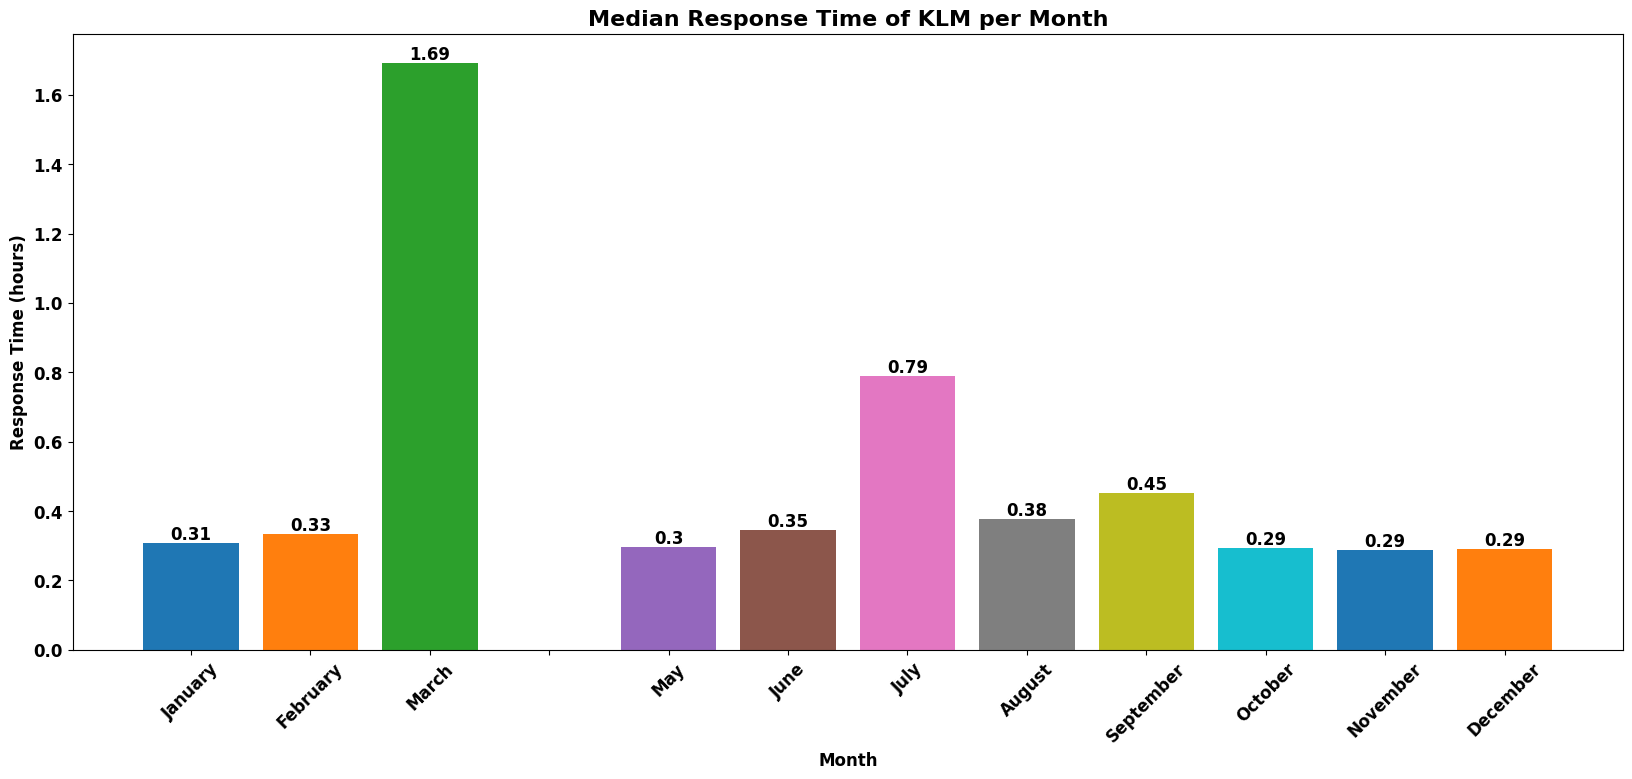

posx and posy should be finite values
posx and posy should be finite values


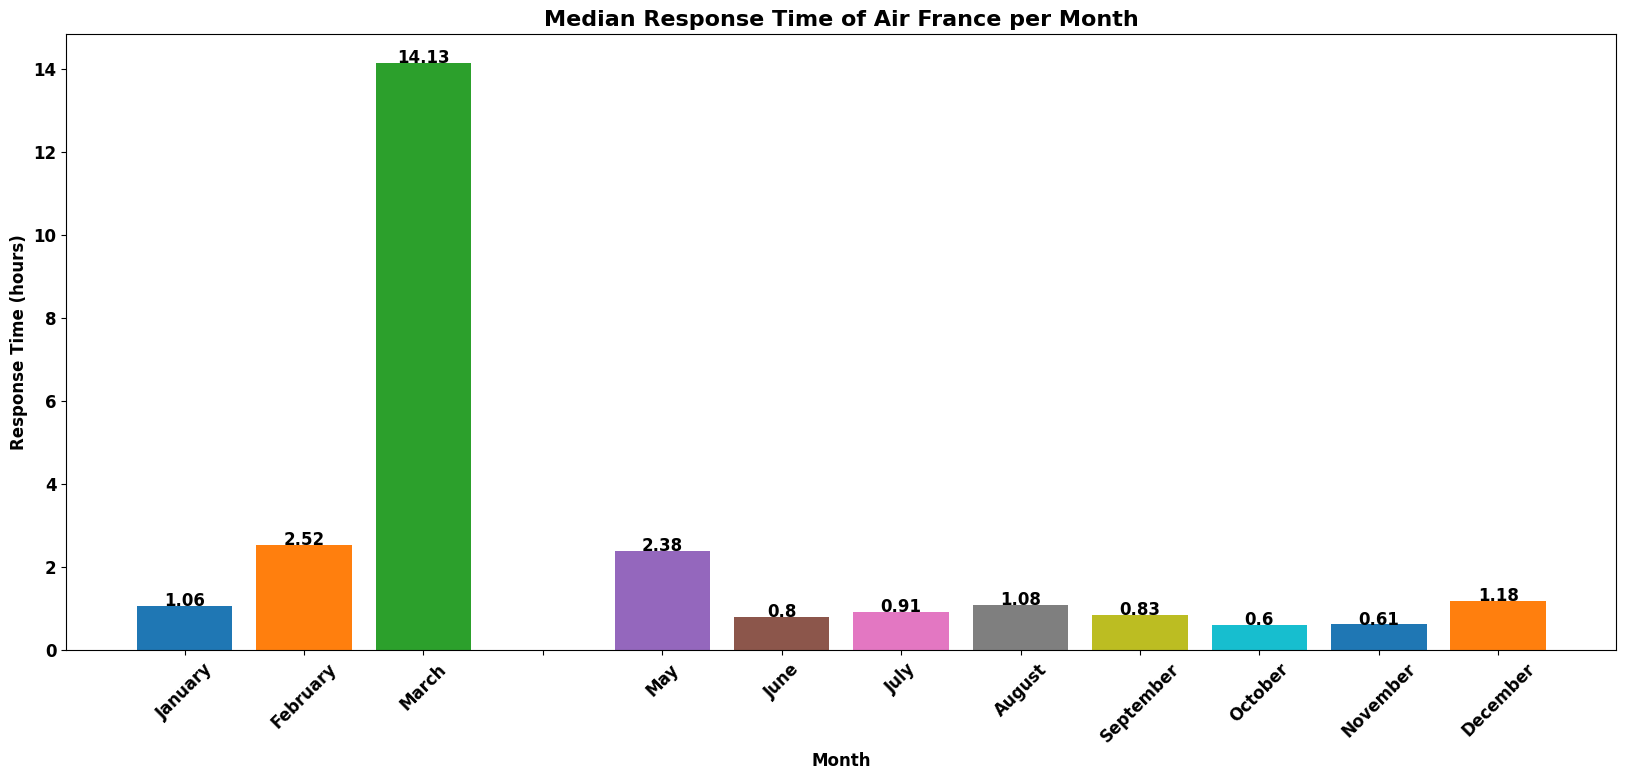

In [124]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract month from the tweet creation time
lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()

# Aggregate and compute the average response time for each month
average_response_times_per_month = lufthansa_replies.groupby('month')['response_time'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(average_response_times_per_month.index, average_response_times_per_month.values, color=colors[:len(average_response_times_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of Lufthansa per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

#dwqjdioqwjdiojqwidojqwiodjqwjdioqwjdioqwjdioqwjdijqwiodjqwio

# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Klm']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract month from the tweet creation time
lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()

# Aggregate and compute the average response time for each month
average_response_times_per_month = lufthansa_replies.groupby('month')['response_time'].median().reindex([
    'January', 'February', 'March', '', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(average_response_times_per_month.index, average_response_times_per_month.values, color=colors[:len(average_response_times_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of KLM per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

#diowjqdiqwjdiqwjdioqwj

# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Air France']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract month from the tweet creation time
lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()

# Aggregate and compute the average response time for each month
average_response_times_per_month = lufthansa_replies.groupby('month')['response_time'].median().reindex([
    'January', 'February', 'March', '', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(average_response_times_per_month.index, average_response_times_per_month.values, color=colors[:len(average_response_times_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of Air France per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')



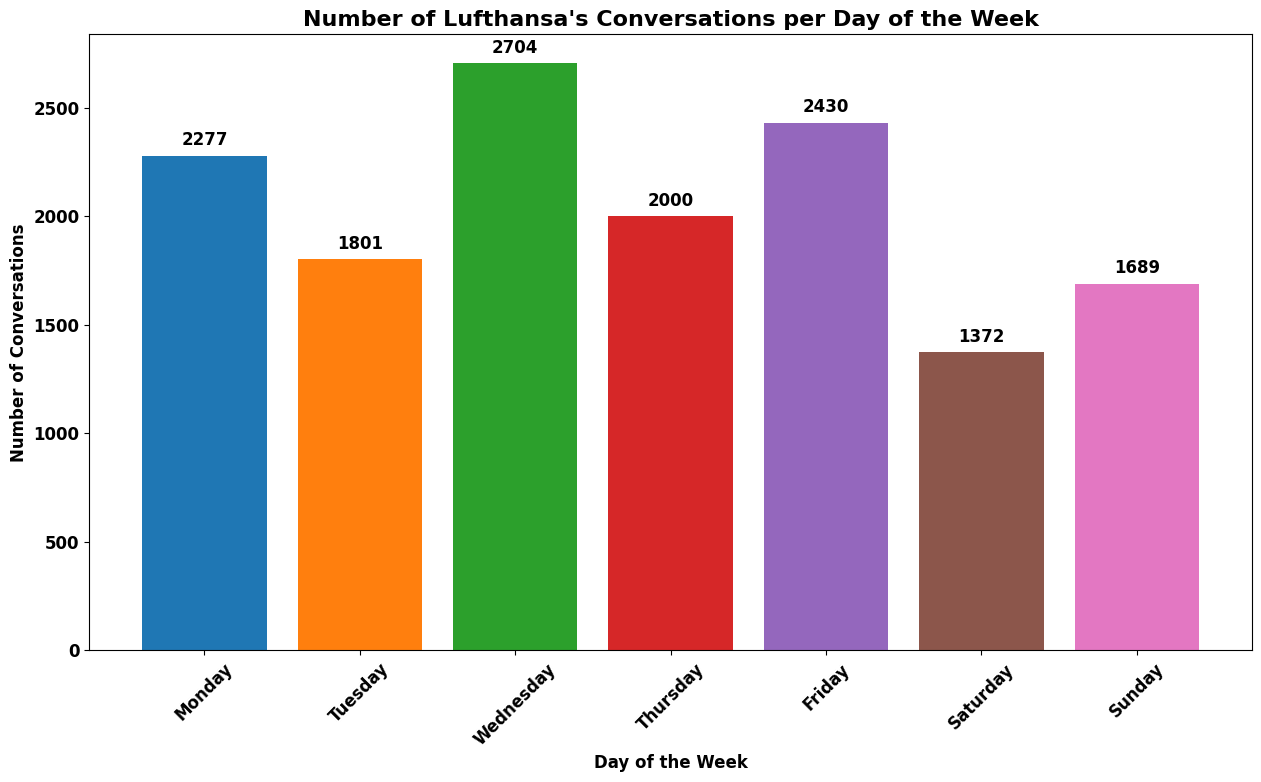

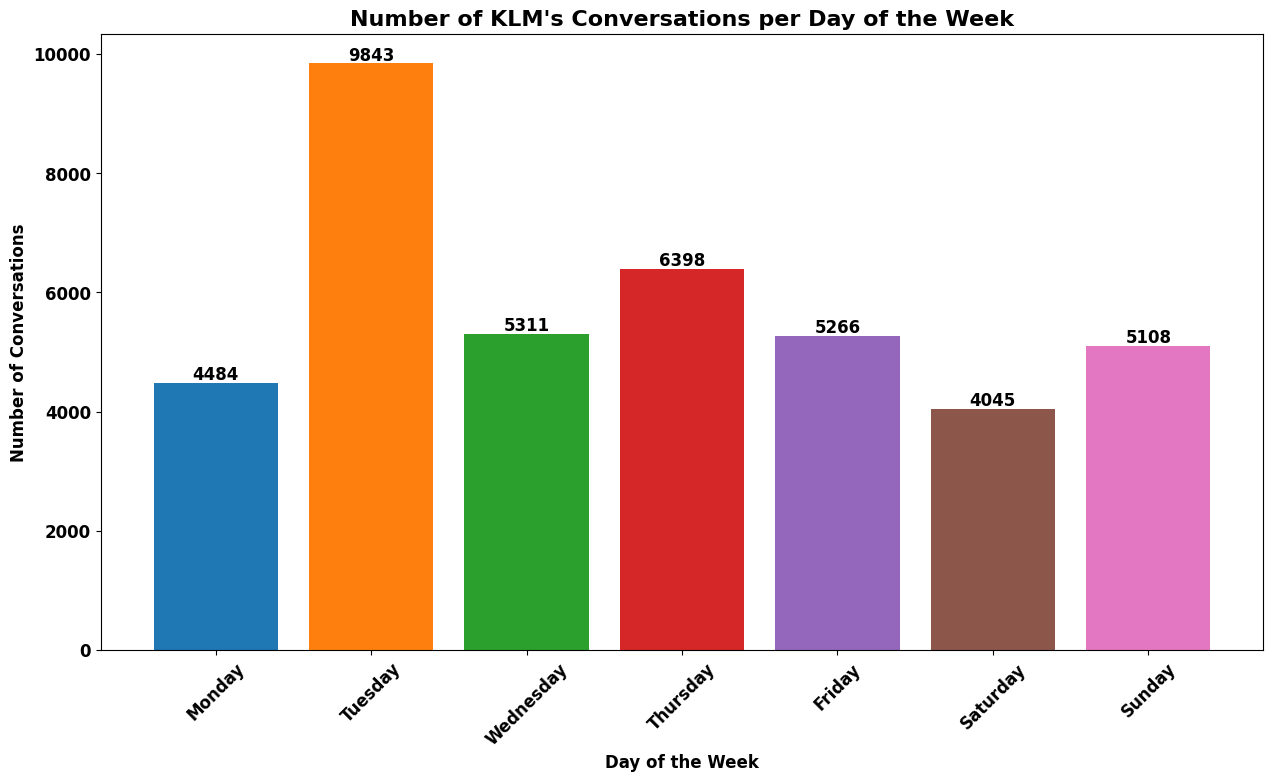

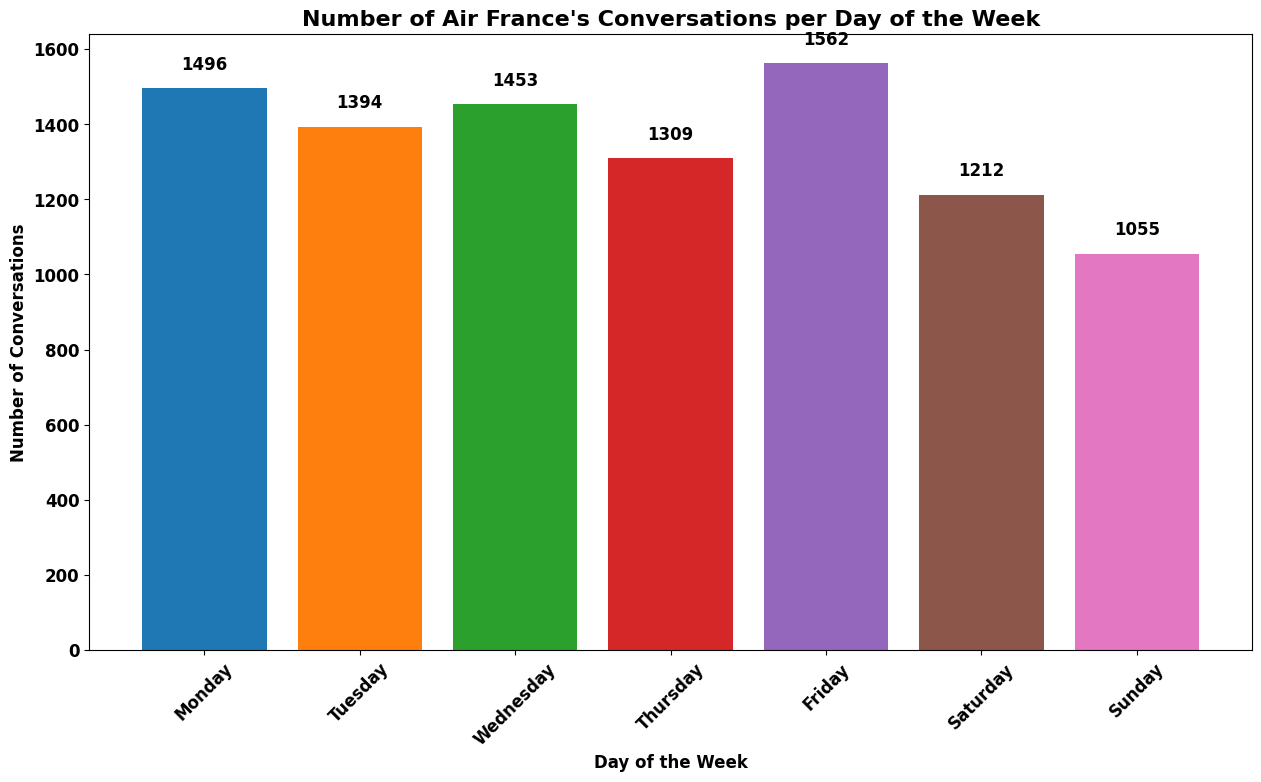

In [126]:
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the day name from the tweet creation time
first_tweet_times_day = first_tweet_times.dt.day_name()

# Group by day name and count the number of conversations
conversations_per_day = first_tweet_times_day.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title("Number of Lufthansa's Conversations per Day of the Week", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold')

#djiowqjdoiqwjdoiqwjdoijqwoidjqwoidjqwiodjqwoidqwiojd
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Klm"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the day name from the tweet creation time
first_tweet_times_day = first_tweet_times.dt.day_name()

# Group by day name and count the number of conversations
conversations_per_day = first_tweet_times_day.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title("Number of KLM's Conversations per Day of the Week", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold')
#iodwqjdiojqwiodjwqiodjqwiodjioqwdioqjw
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Air France"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the day name from the tweet creation time
first_tweet_times_day = first_tweet_times.dt.day_name()

# Group by day name and count the number of conversations
conversations_per_day = first_tweet_times_day.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title("Number of Air France's Conversations per Day of the Week", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold')


C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\2190558625.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['day_of_week'] = lufthansa_replies['tweet_creation_time'].dt.day_name()


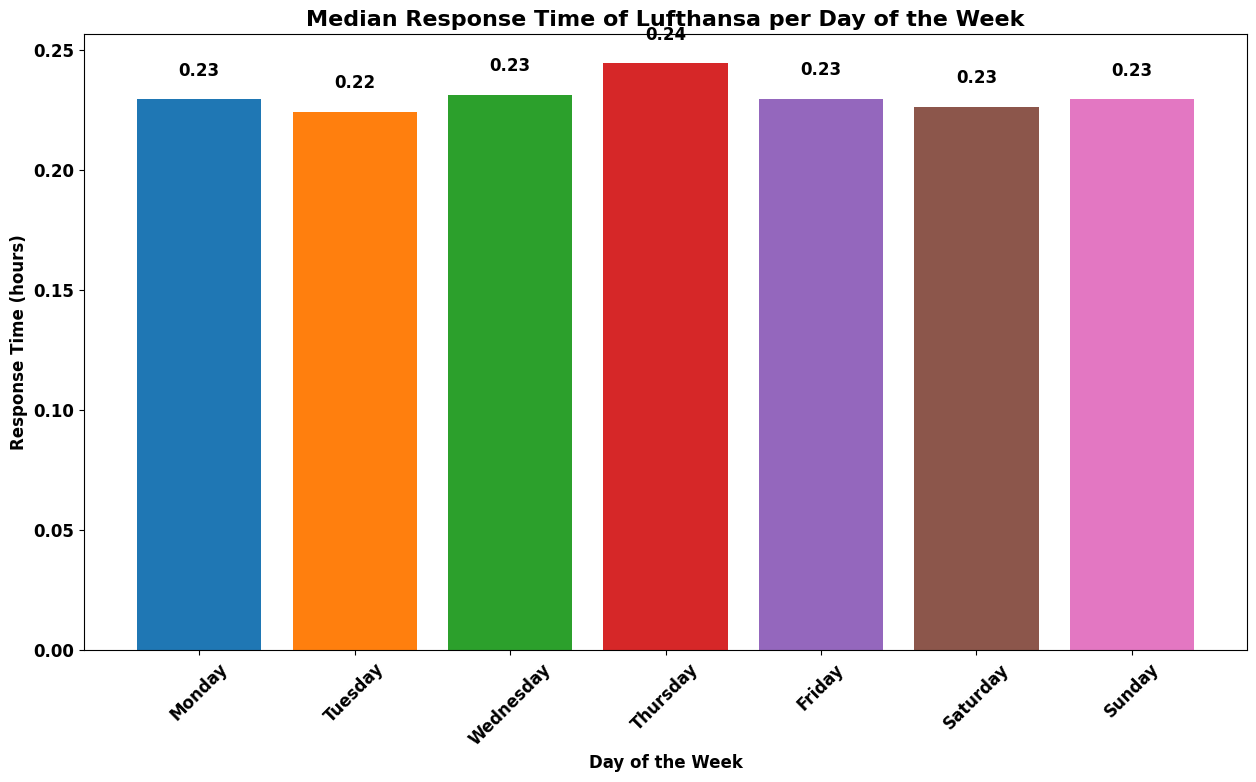

C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\2190558625.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['day_of_week'] = lufthansa_replies['tweet_creation_time'].dt.day_name()


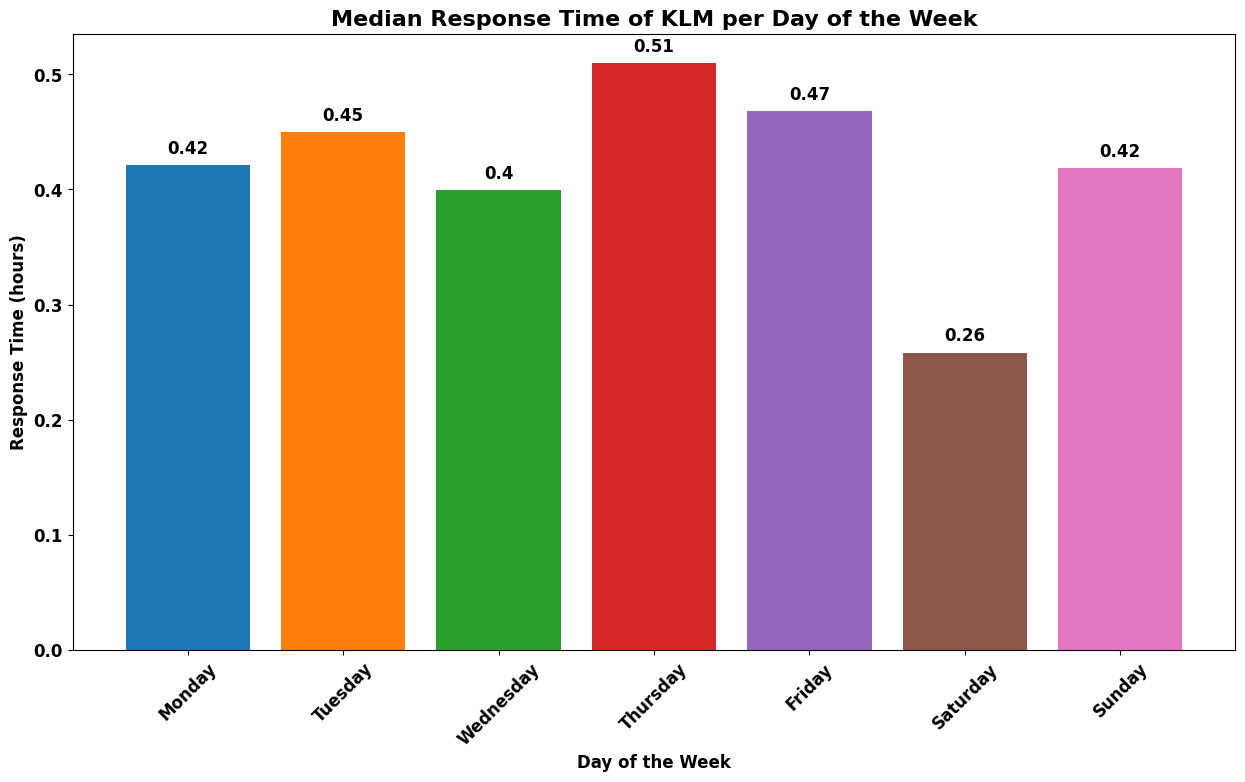

C:\Users\20231596\AppData\Local\Temp\ipykernel_7796\2190558625.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['day_of_week'] = lufthansa_replies['tweet_creation_time'].dt.day_name()


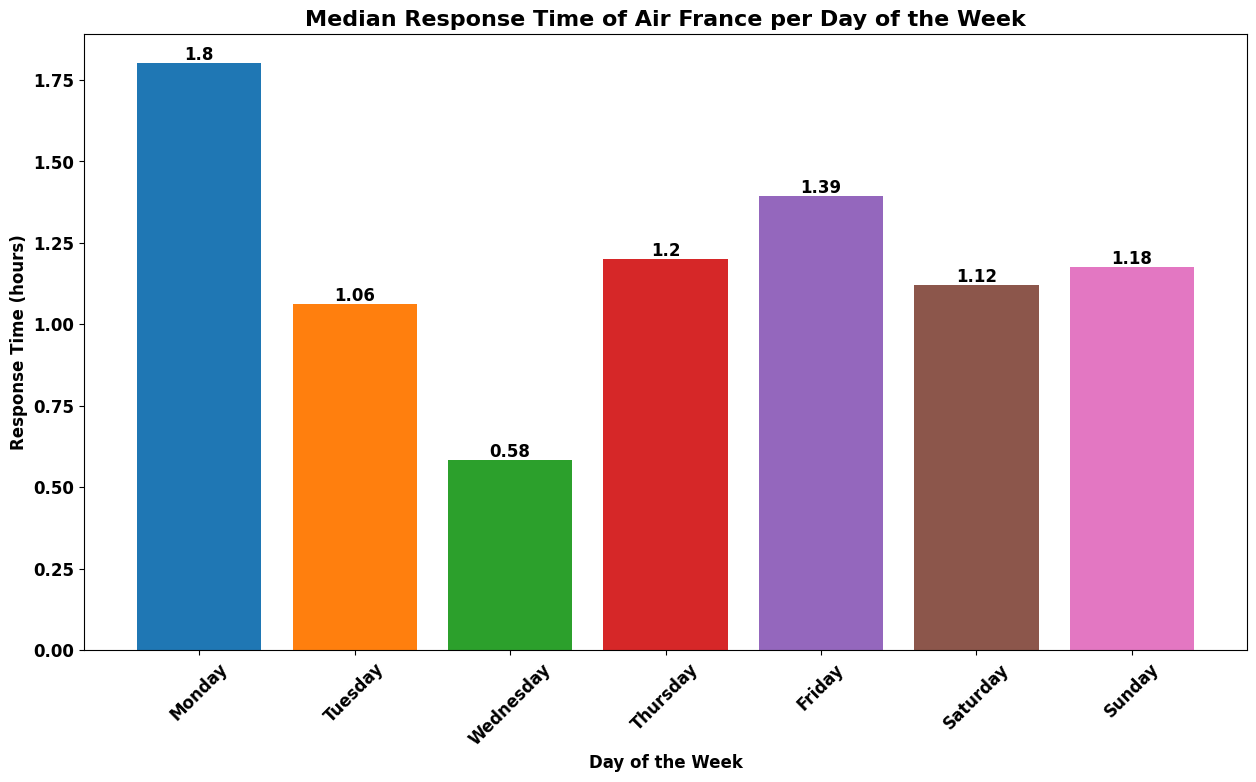

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract the day of the week from the tweet creation time
lufthansa_replies['day_of_week'] = lufthansa_replies['tweet_creation_time'].dt.day_name()

# Aggregate and compute the median response time for each day of the week
median_response_times_per_day = lufthansa_replies.groupby('day_of_week')['response_time'].median().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(median_response_times_per_day.index, median_response_times_per_day.values, color=colors[:len(median_response_times_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of Lufthansa per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.show()
#oiwqjqdiojqwoidjqwoidjowqijdoiqwjdoiqwjdoiqwdiojqwoj
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Klm']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract the day of the week from the tweet creation time
lufthansa_replies['day_of_week'] = lufthansa_replies['tweet_creation_time'].dt.day_name()

# Aggregate and compute the median response time for each day of the week
median_response_times_per_day = lufthansa_replies.groupby('day_of_week')['response_time'].median().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(median_response_times_per_day.index, median_response_times_per_day.values, color=colors[:len(median_response_times_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of KLM per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.show()

#iodwjqoidjwqiodjiqwjdioqwjdioqwjdiojqwidojqw
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Air France']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract the day of the week from the tweet creation time
lufthansa_replies['day_of_week'] = lufthansa_replies['tweet_creation_time'].dt.day_name()

# Aggregate and compute the median response time for each day of the week
median_response_times_per_day = lufthansa_replies.groupby('day_of_week')['response_time'].median().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(median_response_times_per_day.index, median_response_times_per_day.values, color=colors[:len(median_response_times_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of Air France per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.show()

